Instruction:

1.  Mount the google drive 
from google.colab import drive
drive.mount('/content/drive')

2. Load the data packages from the google drive to Colab 
!unzip -qq drive/MyDrive/uw-cs480-fall20.zip -d /content/480data 

3. Download the pre-trained glove word embedding 
!wget http://nlp.stanford.edu/data/glove.6B.zip

4. Unzip the zip file to the google drive 
!unzip glove*.zip -d "/content/drive/MyDrive/Colab Notebooks/680 project"

5. After running each of the models, the best-performed model will be automatically saved under the directory(google drive)
-"/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5"
You can directly load the model from the above directory after training the model




Mount the google drive to Colab


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the images to the Colab from google drive


In [3]:

!unzip -qq drive/MyDrive/uw-cs480-fall20.zip -d /content/480data 


Import all the relavant library

In [4]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf 
from numpy import array
from numpy import argmax

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import sys
import time
import pickle
import os
import re
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional,Conv1D,MaxPooling1D,Reshape,MaxPool2D,Concatenate,Flatten,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,SpatialDropout2D
from keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt
from keras.initializers import Constant


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from tensorflow.keras import regularizers

from keras.callbacks import ModelCheckpoint


Read the file and images 

In [5]:
TRAIN_FILE = "/content/480data/train.csv"
TEST_DATA_FILE = "/content/480data/test.csv"
IMG = "/content/480data/suffled-images/shuffled-images/*.jpg"
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_DATA_FILE)
trainingId= train['id'].tolist()
testingId = test['id'].tolist()
print("training data shape",train.shape)
print("testing data shape",test.shape)


training data shape (21627, 7)
testing data shape (21628, 6)


Load the training images and testing images respectively 
Do the scaling

In [6]:
image_list_training = []
image_list_testing = []
image_label_training =[]
image_label_testing = []
imageLabel=[]
for filename in glob.glob(IMG):
    fileLabel = filename.split("/")[-1].split(".")[0]
    imageLabel.append(fileLabel)
    im=Image.open(filename)
    if(int(fileLabel) in trainingId):
      image_list_training.append(np.asarray(im).astype('float32')/255)
      image_label_training.append(int(fileLabel))
    if(int(fileLabel) in testingId):
      image_list_testing.append(np.asarray(im).astype('float32')/255)
      image_label_testing.append(int(fileLabel))
      
      


    
    



Preprocess the data

In [7]:
# Clean the text data 
def preprocessText(s):
    t = re.sub(r'[0-9]+\.[0-9]+|[A-z0-9]*-[A-z0-9]*-[A-z0-9]*|\([A-z0-9]*\)|[A-Z0-9]+[0-9]+|[0-9]+[A-Z0-9]*|[A-Z]+-[0-9]+', "",s).strip()
    return re.sub(' +', ' ', t)



In [8]:
label = train['category']
label


# # features
train['noisyTextDescription'] = train['noisyTextDescription'].str.replace('\W', ' ')

descriptionFeatures = train.iloc[:,-1:]
descriptionFeatures = descriptionFeatures.values.tolist()

newPreprocessText = []
for string in descriptionFeatures:
  newPreprocessText.append(preprocessText(string[0]))

newPreprocessText = pd.DataFrame (newPreprocessText,columns=['noisyTextDescription'])

train_text = pd.concat([train['category'],newPreprocessText],axis=1)  
newPreprocessText


,noisyTextDescription
0,Femella Women Ankle Length Grey AQ WD
1,Converse Unisex Casual Skirts Slipper
2,Velia Women Acetone Kurta
3,Enroute Men Leather Brown Sandals
4,Aneri Exclusive Anu Pink Inspirartion
...,...
21622,SHE D Men Black Briefs
21623,Adipower Taylor Men Brown Quince
21624,Rocia Women Flats
21625,Fastrack Men Black Amethyst Watch


Preprocess the text description

In [9]:
# Turn the categorical data to one hot vector
from sklearn.preprocessing import LabelBinarizer
features= list(train.columns.values)[2:6]

result_df=train['id']
for feature in features:
  lb = LabelBinarizer()
  lb_results = lb.fit_transform(train[feature])

  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  result_df = pd.concat([result_df,  lb_results_df], axis=1)

newTable = pd.concat([result_df,train_text['noisyTextDescription']],axis=1)
newTable.shape

result_df

,id,Boys,Girls,Men,Unisex,Women,Beige,Black,Blue,Bronze,Brown,Burgundy,Charcoal,Coffee Brown,Copper,Cream,Fluorescent Green,Gold,Green,Grey,Grey Melange,Khaki,Lavender,Lime Green,Magenta,Maroon,Mauve,Metallic,Multi,Mushroom Brown,Mustard,Navy Blue,Nude,Off White,Olive,Orange,Peach,Pink,Purple,Red,Rose,Rust,Sea Green,Silver,Skin,Steel,Tan,Taupe,Teal,Turquoise Blue,White,Yellow,Fall,Spring,Summer,Winter,Casual,Ethnic,Formal,Party,Smart Casual,Sports,Travel
0,36274,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,15129,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,58976,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,32922,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,29561,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21622,5435,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
21623,27880,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
21624,38385,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
21625,34853,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


Product category mapping 

In [10]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
genderType= train["gender"].value_counts().index.tolist()
baseColorType= train["baseColour"].value_counts().index.tolist()

seasonType= train["season"].value_counts().index.tolist()
usageType= train["usage"].value_counts().index.tolist()
labelType= train["category"].value_counts().index.tolist()

print(len(genderType),len(baseColorType),len(seasonType),len(usageType))
noisyTextDescriptionType= train["noisyTextDescription"].value_counts().index.tolist()

# define example
values = array(labelType)
mapping ={}
categories =sorted(labelType)
print(values)
for i in range(len(labelType)):
  mapping[categories[i]]=i

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

onehot_labels = []
for data in label:
  map = mapping[data]
  onehot_labels.append(onehot_encoded[map])
mapping


5 46 4 7
['Topwear' 'Shoes' 'Bags' 'Bottomwear' 'Watches' 'Innerwear' 'Eyewear'
 'Jewellery' 'Fragrance' 'Sandal' 'Flip Flops' 'Wallets' 'Belts' 'Socks'
 'Dress' 'Loungewear and Nightwear' 'Saree' 'Lips' 'Nails' 'Ties'
 'Headwear' 'Makeup' 'Accessories' 'Free Gifts' 'Apparel Set' 'Scarves'
 'Cufflinks']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


{'Accessories': 0,
 'Apparel Set': 1,
 'Bags': 2,
 'Belts': 3,
 'Bottomwear': 4,
 'Cufflinks': 5,
 'Dress': 6,
 'Eyewear': 7,
 'Flip Flops': 8,
 'Fragrance': 9,
 'Free Gifts': 10,
 'Headwear': 11,
 'Innerwear': 12,
 'Jewellery': 13,
 'Lips': 14,
 'Loungewear and Nightwear': 15,
 'Makeup': 16,
 'Nails': 17,
 'Sandal': 18,
 'Saree': 19,
 'Scarves': 20,
 'Shoes': 21,
 'Socks': 22,
 'Ties': 23,
 'Topwear': 24,
 'Wallets': 25,
 'Watches': 26}

In [11]:
# Image category label in one hot vector form 
training_category_label = []

for id in image_label_training:
  newLabel = mapping[train[train['id']==id]['category'].values[0]]
  onehot_newLabel =onehot_encoded[newLabel]
  training_category_label.append(onehot_newLabel)

Append the categorical data to text description

In [14]:
import re
train.iloc(1) 
detailDescription=[]
noCategorical = []
for index, row in train.iterrows():
  add = row['gender']+" "+row['baseColour']+" "+row['season']+" "+row['usage']+" "+row['noisyTextDescription']
  #add=row['noisyTextDescription']
  detailDescription.append(add)
detailDescription=np.array(detailDescription)
detailDescription=pd.DataFrame(detailDescription,columns=["noisyTextDescription"])



descriptionFeatures = detailDescription.values.tolist()
newPreprocessText = []
lenght= []
for string in descriptionFeatures:
  lenght.append(len(re.findall(r'\w+', preprocessText(string[0])) ))
  newPreprocessText.append(preprocessText(string[0]))
print(newPreprocessText)
newPreprocessText = pd.DataFrame (newPreprocessText,columns=['noisyTextDescription'])
newPreprocessText


['Women Grey Summer Casual Femella Women Ankle Length Grey AQ WD', 'Unisex Green Summer Casual Converse Unisex Casual Skirts Slipper', 'Women Red Summer Ethnic Velia Women Acetone Kurta', 'Men Brown Summer Casual Enroute Men Leather Brown Sandals', 'Women Pink Fall Ethnic Aneri Exclusive Anu Pink Inspirartion', 'Women Multi Summer Casual Envirosax Women Multi Corp', 'Men Black Summer Casual Playboy Begining Tights Skt', 'Women White Summer Casual Femella Women White ComfortSoft Shirt', 'Women Blue Summer Ethnic Avirate Women Blue Chanderi Dupatta', 'Women Red Fall Casual Lotto Women Virtue CSM LTP D', 'Men Brown Summer Casual Arrow Men No Check Scarf', 'Women Grey Winter Casual Murcia Women Grey Convertable Handbag', 'Women Purple Fall Casual Scullers For Her Women Solid Purple Tunic', 'Women Black Winter Casual Aug Women Black Dial Gal', 'Men Blue Fall Casual Spykar Men Stripes Blue Sweaters', 'Men Navy Blue Fall Formal Scullers loma Scul Search Shirts', 'Women Black Winter Casual Fas

,noisyTextDescription
0,Women Grey Summer Casual Femella Women Ankle L...
1,Unisex Green Summer Casual Converse Unisex Cas...
2,Women Red Summer Ethnic Velia Women Acetone Kurta
3,Men Brown Summer Casual Enroute Men Leather Br...
4,Women Pink Fall Ethnic Aneri Exclusive Anu Pin...
...,...
21622,Men Black Summer Casual SHE D Men Black Briefs
21623,Men Brown Summer Casual Adipower Taylor Men Br...
21624,Women Beige Winter Casual Rocia Women Flats
21625,Men Steel Winter Casual Fastrack Men Black Ame...


MODEL1: using tfidf with 2-ngrams as the input feature and use SVM to do the classification

In [12]:
from sklearn.pipeline import Pipeline
from sklearn import svm
import pickle
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

def modelTF ():
  text_clf = Pipeline([
      ('vect', CountVectorizer(analyzer='word',ngram_range=(1,2))),
      ('tfidf', TfidfTransformer()),
      ('clf', svm.SVC()),
  ])
  text_clf.fit(np.asarray(X_train_text), np.asarray(y_train_text))
  s = dump(text_clf, '/content/drive/MyDrive/Colab Notebooks/680 project/tf-idf') 
  return text_clf



Download the glove word embedding 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


In [ ]:
!unzip glove*.zip -d "/content/drive/MyDrive/Colab Notebooks/680 project"

Model 2: Using the pre-trained word embedding to train the model

In [28]:
from keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import math
import matplotlib.pyplot as plt
from keras.regularizers import l1_l2
def modelGlove(training):

  vocab_size = 1000
  oov_token = "<OOV>"
  max_length = 100
  padding_type = "post"
  trunction_type="post"
  tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
  tokenizer.fit_on_texts(X_train_text)
  word_index = tokenizer.word_index
  #sequences = tokenizer.texts_to_sequences(X_train_text['noisyTextDescription'].values)
  sequences = tokenizer.texts_to_sequences(X_train_text)
  sequences_matrix_train = sequence.pad_sequences(sequences,maxlen=max_len, padding=padding_type, 
                        truncating=trunction_type)
  
  print('Indexing word vectors.')

  sequencestesting = tokenizer.texts_to_sequences(X_test_text)
  sequences_matrix_test = sequence.pad_sequences(sequencestesting,maxlen=max_len, padding=padding_type, 
                    truncating=trunction_type)

  embeddings_index = {}
  f = open('/content/drive/MyDrive/Colab Notebooks/680 project/glove.6B.100d.txt', encoding='utf-8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()

  print('Found %s word vectors.' % len(embeddings_index))

  embedding_matrix = np.zeros((len(word_index) + 1, max_length))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

  embedding_layer = Embedding(len(word_index) + 1,
                              max_length,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False)


  embedding_dim = 100
  input_length = 18
  model = Sequential([
      embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim,)),
    Dropout(0.2),

    Dense(27, activation='sigmoid')
  ])


  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  save_best_model = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_glove.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  history = model.fit(sequences_matrix_train, y_train_text, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001),save_best_model])
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  if(training):
    loss,acc = model.evaluate(sequences_matrix_test,y_test_text)
    print("evaluation",model.evaluate(sequences_matrix_test,y_test_text))
  
  load = load_model("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_glove.h5")
  pred = load.predict(np.asarray(sequences_matrix_train))
  pre = load.predict(sequences_matrix_test)
  print(classification_report(np.argmax(y_train_text,axis=1), np.argmax(pred,axis=1)))
  #return np.argmax(pre,axis=1)
  return pre


Model3: Classic CNN model with the option of enabling or disabling the augmentation 

In [33]:
# cnn
def model_CNN(aug):
  # building a linear stack of layers with the sequential model
  model_CNN = Sequential()

  # convolutional layer
  model_CNN.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(80,60,3)))

  # convolutional layer 32
  model_CNN.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  model_CNN.add(layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  model_CNN.add(layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  # flatten output of conv
  model_CNN.add(layers.Flatten())

  # hidden layer
  model_CNN.add(layers.Dense(128, activation='relu'))
  model_CNN.add(layers.Dropout(0.3))
  #Output layer
  model_CNN.add(layers.Dense(27, activation='softmax'))

  # compiling the sequential model
  model_CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

  if(aug):

      datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0
            )
      # save_best_model = ModelCheckpoint('best_model_cnnAug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

      history = model_CNN.fit(datagen.flow(np.asarray(X_train_image), np.asarray(y_train_image), batch_size=16),
                            epochs=30)
      pred = model_CNN.predict(np.asarray(X_train_image))
      print(classification_report(np.argmax(y_train_image,axis=1), np.argmax(pred,axis=1)))
  else:
      save_best_model = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

      history =model_CNN.fit(np.asarray(X_train_image), np.asarray(y_train_image), batch_size=16, epochs=50, validation_split=0.2, callbacks=[save_best_model])
      load = load_model("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5")
      pred = load.predict(np.asarray(X_train_image))
      print(classification_report(np.argmax(y_train_image,axis=1), np.argmax(pred,axis=1)))
  return model_CNN



Model 4:
CNN model with first 12 epochs with augmentation and the rest of the epochs without augmentation

In [18]:
# cnn
def model_2CNN():
  # building a linear stack of layers with the sequential model
  model_CNN = Sequential()

  # convolutional layer
  model_CNN.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(80,60,3)))

  # convolutional layer 32
  model_CNN.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  model_CNN.add(layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  model_CNN.add(layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  # flatten output of conv
  model_CNN.add(layers.Flatten())

  # hidden layer
  model_CNN.add(layers.Dense(128, activation='relu'))
  model_CNN.add(layers.Dropout(0.3))
  #Output layer
  model_CNN.add(layers.Dense(27, activation='softmax'))

  # compiling the sequential model
  opt = keras.optimizers.Adam(learning_rate=0.0001)

  model_CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)


  datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
        )
  # save_best_model = ModelCheckpoint('best_model_cnnAug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  history = model_CNN.fit(datagen.flow(np.asarray(X_train_image), np.asarray(y_train_image), batch_size=16),epochs=12)

  save_best_model = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn2.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  history =model_CNN.fit(np.asarray(X_train_image), np.asarray(y_train_image), batch_size=16, epochs=50, validation_split=0.2, callbacks=[save_best_model])
  
  load = load_model("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn2.h5")
  pred = load.predict(np.asarray(X_train_image))
  print(classification_report(np.argmax(y_train_image,axis=1), np.argmax(pred,axis=1)))
  return model_CNN
#

Combine 2 CNN model(one for text and one for image) and concatenate two models into one multilayer neural network

In [32]:
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import ModelCheckpoint
from numpy import zeros, newaxis


trainingImageEnsemble = image_list_training
y_train_ensemble = training_category_label
#  #vectorizer = TfidfVectorizer(max_features=6000, use_idf=True)
# vectorizer = TfidfVectorizer(max_features=6000, use_idf=True,ngram_range=(1,3))

# vectorizer = vectorizer.fit(newPreprocessText['noisyTextDescription'].values)
# tf_len = len(vectorizer.vocabulary_)
# TF_X_train = vectorizer.transform(newPreprocessText['noisyTextDescription'].values).astype('float64')
# TF_X_train = TF_X_train.todense()
# print(TF_X_train.shape)
# TF_X_train.reshape(TF_X_train.shape[0], TF_X_train.shape[1],1)
# TF_X_train= TF_X_train[:,:,newaxis]

def combineModel():
  ## create model
  model_glove = Sequential()
  model_glove.add(Embedding(len(word_index) + 1, 100, input_length=100, weights=[embedding_matrix], trainable=False))
  model_glove.add(Dropout(0.2))
  model_glove.add(Conv1D(128, 3, 
                     padding='valid',
                     activation='relu',
                     strides=1))
  model_glove.add(MaxPooling1D(pool_size=4))

  model_glove.add(Dropout(0.2))
  model_glove.add(Conv1D(128, 3, 
                     padding='valid',
                     activation='relu',
                     strides=1))
  model_glove.add(MaxPooling1D(pool_size=2))
  model_glove.add(Dropout(0.2))
  model_glove.add(LSTM(100, recurrent_dropout=0.2))
  
  model_glove.add(Flatten())
  model_glove.add(layers.Dense(128, activation='relu'))


  model_CNN = Sequential()
  # convolutional layer
  model_CNN.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(80,60,3)))

  # convolutional layer 32
  model_CNN.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))

  #125
  model_CNN.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model_CNN.add(layers.MaxPool2D(pool_size=(2,2)))
  model_CNN.add(layers.Dropout(0.2))
  # # flatten output of conv
  model_CNN.add(layers.Flatten())
  model_CNN.add(layers.Dense(128, activation='relu'))

  # Concatenate model
  modeltmp = concatenate([model_glove.output,model_CNN.output], axis=1)
  modeltmp = Flatten()(modeltmp)

  modeltmp = Dropout(0.25)(modeltmp)
  modeltmp = Dense(128, activation='relu')(modeltmp)
  modeltmp = Dropout(0.25)(modeltmp)
  modeltmp = Dense(128, activation='relu')(modeltmp)
  modeltmp = Dropout(0.25)(modeltmp)


  modeltmp = Dense(27, activation='softmax')(modeltmp)
  #modeltmp = Model(inputs=[model_glove.input, model1.input,model_CNN.input], outputs=modeltmp)
  modeltmp = Model(inputs=[model_glove.input,model_CNN.input], outputs=modeltmp)
  check_point = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
  early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
  opt = keras.optimizers.Adam(learning_rate=0.0008)


 
  modeltmp.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  modeltmp.fit([np.asarray(X_train_text),np.asarray(trainingImageEnsemble)], np.asarray(y_train_ensemble),  validation_split = 0.2, epochs=50,callbacks=[check_point])
  # modeltmp.fit([np.asarray(TF_X_train), np.asarray(Train), np.asarray(trainingImageEnsemble)], np.asarray(y_train_ensemble),  validation_split = 0.1, epochs=50,callbacks=[check_point, early_stop])

  load = load_model("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5")
  pred = load.predict([np.asarray(X_train_text),np.asarray(trainingImageEnsemble)])
  print(classification_report(np.argmax(y_train_ensemble,axis=1), np.argmax(pred,axis=1)))
  return modeltmp


for categorical data

In [13]:

def model_MLP():
  model_MLP = keras.models.Sequential()
  model_MLP.add(keras.layers.Dense(64, input_shape=(62,)))
  model_MLP.add(keras.layers.core.Dense(128, activation='relu'))

  model_MLP.add(keras.layers.core.Dense(27,  activation='sigmoid'))
  model_MLP.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy","categorical_crossentropy"])
  callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
  check_point = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/680 project/best_model_mlp.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

  model_MLP.fit(X_train, y_train, batch_size=8, epochs=30,validation_split=0.1,  verbose=1, callbacks=[callback_early_stopping,check_point])

  return model_MLP





TRAIN THE MODEL USING ALL THE DATA AND TEST ON TEST SET

In [15]:
#All the training data set 
Train = result_df.drop('id',axis=1)
print(Train.shape,len(onehot_labels))
Train

(21627, 62) 21627


,Boys,Girls,Men,Unisex,Women,Beige,Black,Blue,Bronze,Brown,Burgundy,Charcoal,Coffee Brown,Copper,Cream,Fluorescent Green,Gold,Green,Grey,Grey Melange,Khaki,Lavender,Lime Green,Magenta,Maroon,Mauve,Metallic,Multi,Mushroom Brown,Mustard,Navy Blue,Nude,Off White,Olive,Orange,Peach,Pink,Purple,Red,Rose,Rust,Sea Green,Silver,Skin,Steel,Tan,Taupe,Teal,Turquoise Blue,White,Yellow,Fall,Spring,Summer,Winter,Casual,Ethnic,Formal,Party,Smart Casual,Sports,Travel
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21622,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
21623,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
21624,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
21625,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


Preprocess the test dataset 

In [14]:
test = pd.read_csv(TEST_DATA_FILE)
test_df = test['id']
for feature in features:
  lb = LabelBinarizer()
  lb_test = lb.fit_transform(test[feature])
  lb_results_test = pd.DataFrame(lb_test, columns=lb.classes_)
  test_df = pd.concat([test_df,  lb_results_test], axis=1)

test_id = test_df['id']
test_df=test_df.drop(['id'], axis=1)

Preprocess the test dataset 

In [16]:
import re
train.iloc(1) 

detailDescription_test=[]
for index, row in test.iterrows():
  add = row['gender']+" "+row['baseColour']+" "+row['season']+" "+row['usage']+" "+row['noisyTextDescription']
  #add = row['noisyTextDescription']
  detailDescription_test.append(add)
detailDescription_test=np.array(detailDescription_test)
detailDescription_test=pd.DataFrame(detailDescription_test,columns=["noisyTextDescription"])
descriptionFeatures_test = detailDescription_test.values.tolist()
newPreprocessText_test = []
lenght= []
print(descriptionFeatures_test)
for string in descriptionFeatures_test:
  newPreprocessText_test.append(preprocessText(string[0]))
newPreprocessText_test = pd.DataFrame (newPreprocessText_test,columns=['noisyTextDescription'])
print(newPreprocessText_test)

max_words = 10000
max_len = 18



# FOR RNN model
tok = Tokenizer(num_words=max_words,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tok.fit_on_texts(newPreprocessText_test['noisyTextDescription'].values)
sequences_test = tok.texts_to_sequences(newPreprocessText_test['noisyTextDescription'].values)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)
sequences_matrix_test
# For pre-trained glove model
vocab_size = 1000
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(newPreprocessText_test['noisyTextDescription'].values)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(newPreprocessText_test['noisyTextDescription'].values)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len, padding=padding_type, 
                  truncating=trunction_type)

[['Men Black Summer Casual Chromozome Men Black Fashion Vest'], ['Women Green Summer Casual Elle Women Green Color Clash Top'], ['Women Black Winter Casual Baggit Women Chotu Mayur Black Palms'], ['Men Black Fall Casual Greensboro Colors Of Ap Men Latnam Black Casual Shoes'], ['Women Purple Summer Casual Fish White Smooth daddy (SH100)'], ['Men Olive Winter Casual Red Chief Men Olive Casual Shoes'], ['Women Yellow Summer Casual Myntra PL13090JSG-28A Yellow T-shirt'], ['Women Black Winter Casual M tv Women My Fab Eyewear Black Sunglasses'], ['Women Black Spring Casual Guess Women Puffy G Black Watch'], ['Men Red Summer Sports Apelido Tone Phoenix Red Shoes'], ['Men Navy Blue Summer Casual Chromozome Men Navy Blue & Red Strawberries'], ['Men Red Fall Casual Boyleg Men Illustrat Red Debbie'], ['Men Grey Summer Casual Park Avenue Frogskins Camera Tie'], ['Men Black Summer Casual Chromozome Men Glamour Briefs'], ["Men Navy Blue Summer Casual Wrangler Men's Navy Ankle Length Socks"], ["Women

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(max_depth=62, random_state=0)
forest = forest.fit(Train, pd.DataFrame(onehot_labels).values.argmax(axis=1))

boostForest = AdaBoostClassifier(n_estimators=100,base_estimator=forest, random_state=0)
boostForest.fit(Train, pd.DataFrame(onehot_labels).values.argmax(axis=1))


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=62,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                         

In [24]:
y_pred_forest = boostForest.predict(test_df)
print(y_pred_forest)

[24 24 21 ... 21 14  2]


In [29]:
saved_model_mlp = load_model('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_mlp.h5')
y_pred_mlp= saved_model_mlp.predict(np.asarray(test_df)) 
y_pred_mlp = np.argmax(y_pred_mlp,axis=1)
print(y_pred_mlp)

[24 24 21 ... 21 14  2]


Using tf-idf to encode the text data and use the svm to classify the data.

In [25]:
X_train_text = np.asarray(newPreprocessText['noisyTextDescription'].values)
y_train_text = pd.DataFrame(onehot_labels).values.argmax(axis=1)
modelTF = modelTF()

Make prediction

In [26]:
y_pred_tf= modelTF.predict(newPreprocessText_test['noisyTextDescription'].values)
print(y_pred_tf)

[12 24  2 ... 24 24  2]


Use the CNN with augmentation for the first several epoches
(since the order of images are not aligned with the order of test data. I will reorder the prediction later)


In [26]:
X_train_image = image_list_training
y_train_image = training_category_label
model_CNN_aug = model_2CNN()


Epoch 1/12
1352/1352 [==============================] - 28s 21ms/step - loss: 1.8014 - accuracy: 0.5314
Epoch 2/12
1352/1352 [==============================] - 28s 20ms/step - loss: 1.2286 - accuracy: 0.6670
Epoch 3/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.9959 - accuracy: 0.7281
Epoch 4/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.8434 - accuracy: 0.7669
Epoch 5/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.7541 - accuracy: 0.7904
Epoch 6/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.6944 - accuracy: 0.8051
Epoch 7/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.6506 - accuracy: 0.8169
Epoch 8/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.6105 - accuracy: 0.8269
Epoch 9/12
1352/1352 [==============================] - 28s 21ms/step - loss: 0.5789 - accuracy: 0.8348
Epoch 10/12
1352/1352 [==============================] - 28s 20m

Make prediction

In [30]:
saved_model_2cnn = load_model('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn2.h5')
y_pred_cnn2 = saved_model_2cnn.predict(np.asarray(image_list_testing)) 
y_pred_cnn2 = np.argmax(y_pred_cnn2,axis=1)
print(y_pred_cnn2)

[17 19  4 ... 26 24 24]


Use the CNN without augmentation to train the model


In [34]:
X_train_image = image_list_training
y_train_image = training_category_label
model_CNN = model_CNN(False)

Epoch 1/50
1082/1082 [==============================] - ETA: 0s - loss: 1.1133 - accuracy: 0.7091
Epoch 00001: val_accuracy improved from -inf to 0.85529, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5
1082/1082 [==============================] - 10s 9ms/step - loss: 1.1133 - accuracy: 0.7091 - val_loss: 0.5063 - val_accuracy: 0.8553
Epoch 2/50
1078/1082 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.8432
Epoch 00002: val_accuracy improved from 0.85529 to 0.88511, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5
1082/1082 [==============================] - 10s 9ms/step - loss: 0.5657 - accuracy: 0.8434 - val_loss: 0.4090 - val_accuracy: 0.8851
Epoch 3/50
1077/1082 [============================>.] - ETA: 0s - loss: 0.4556 - accuracy: 0.8710
Epoch 00003: val_accuracy improved from 0.88511 to 0.89367, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5
1082/1

Make the prediction(since the order of images are not aligned with the order of test data. I will reorder the prediction later)

In [35]:
saved_models_cnn = load_model('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5')

y_pred_cnn = saved_models_cnn.predict(np.asarray(image_list_testing)) 
y_pred_cnn= np.argmax(y_pred_cnn,axis=1)
print(y_pred_cnn)

[17 19  4 ... 26 24 24]


Set up the pretrained glove word embedding

In [30]:
vocab_size = 10000
oov_token = "<OOV>"
max_length = 100
embedding_dim=200
padding_type = "post"
trunction_type="post"
MAX_SEQUENCE_LENGTH = 52
sequence_length = 52


tokenizer = Tokenizer(num_words=vocab_size, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(  newPreprocessText['noisyTextDescription'].values)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences( newPreprocessText['noisyTextDescription'].values)
print("unique words : {}".format(len(word_index)))

sequences_matrix_train = pad_sequences(sequences,maxlen=sequence_length, padding=padding_type, 
                    truncating=trunction_type)

# X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(sequences_matrix_train, pd.DataFrame(onehot_labels), test_size=0.1)
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/680 project/glove.6B.100d.txt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, max_length))

for word, i in word_index.items():
  if i > len(word_index):
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector



trainingImageEnsemble = image_list_training
y_train_ensemble = training_category_label
X_train_text =sequences_matrix_train



unique words : 6837
Found 400000 word vectors.


Run the combined model(2 CNN to one CNN)

In [33]:
combineModel = combineModel()

Epoch 1/50
539/541 [============================>.] - ETA: 0s - loss: 1.3739 - accuracy: 0.6386WARNING:tensorflow:Model was constructed with shape (None, 100) for input Tensor("embedding_1_input:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 52).

Epoch 00001: val_accuracy improved from -inf to 0.80259, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5
541/541 [==============================] - 14s 26ms/step - loss: 1.3728 - accuracy: 0.6389 - val_loss: 0.7693 - val_accuracy: 0.8026
Epoch 2/50
541/541 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.8034
Epoch 00002: val_accuracy improved from 0.80259 to 0.85992, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn.h5
541/541 [==============================] - 14s 25ms/step - loss: 0.7153 - accuracy: 0.8034 - val_loss: 0.4695 - val_accuracy: 0.8599
Epoch 3/50
539/541 [============================>.

Make prediction

In [36]:
saved_models_combine = load_model('/content/drive/MyDrive/Colab Notebooks/680 project/best_model_cnn_text.h5')

reorderImage =[]

for id in test_id:
  index = image_label_testing.index(id)
  reorderImage.append(image_list_testing[index])
y_pred_combine= saved_models_combine.predict([np.asarray(sequences_matrix_test),np.asarray(reorderImage)])
y_pred_combine = (np.argmax(y_pred_combine,axis=1))

print(y_pred_combine)

[24 26 21 ... 24 21 24]


(21627,) (21627, 27) (21628,)
Indexing word vectors.
Found 400000 word vectors.
Epoch 1/30
537/541 [============================>.] - ETA: 0s - loss: 1.1973 - accuracy: 0.6874WARNING:tensorflow:Model was constructed with shape (None, 100) for input Tensor("embedding_input:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 18).

Epoch 00001: val_accuracy improved from -inf to 0.85922, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_glove.h5
541/541 [==============================] - 9s 16ms/step - loss: 1.1925 - accuracy: 0.6887 - val_loss: 0.5770 - val_accuracy: 0.8592
Epoch 2/30
537/541 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.8550
Epoch 00002: val_accuracy improved from 0.85922 to 0.87124, saving model to /content/drive/MyDrive/Colab Notebooks/680 project/best_model_glove.h5
541/541 [==============================] - 7s 13ms/step - loss: 0.5598 - accuracy: 0.8552 - val_loss: 

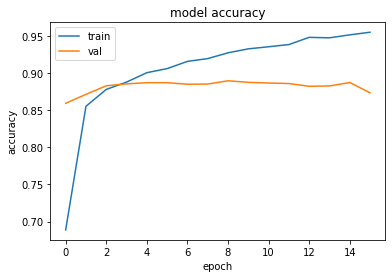

              precision    recall  f1-score   support

           0       0.96      0.75      0.84        64
           1       0.98      0.92      0.95        60
           2       0.91      0.94      0.92      1517
           3       0.98      0.81      0.89       382
           4       0.95      0.80      0.87      1326
           5       1.00      0.92      0.96        50
           6       0.99      0.72      0.84       239
           7       0.97      0.94      0.96       531
           8       0.97      0.92      0.94       461
           9       0.94      0.92      0.93       521
          10       1.00      0.10      0.18        61
          11       0.97      0.77      0.86       128
          12       0.89      0.94      0.91       910
          13       0.95      0.95      0.95       526
          14       0.89      0.91      0.90       193
          15       0.93      0.88      0.90       222
          16       0.91      0.88      0.90       118
          17       0.99    

In [39]:
X_train_text = np.asarray(newPreprocessText['noisyTextDescription'].values)
y_train_text =  np.asarray(onehot_labels)
X_test_text = np.asarray(newPreprocessText_test['noisyTextDescription'].values)
print(X_train_text.shape,y_train_text.shape,X_test_text.shape)
y_pred_glove = modelGlove(False)
print(y_pred_glove)

In [40]:
pre_glove=np.argmax(y_pred_glove,axis=1)
print(pre_glove)

[12 24 24 ... 21 14  2]


Reorder the prediction of CNN and CNN_combined

In [37]:
cnnRes = []
cnnCombined=[]
for id in test_id:
  index = image_label_testing.index(id)
  cnnRes.append(y_pred_cnn[index])
  cnnCombined.append(y_pred_cnn2[index])
print(cnnRes)
print(cnnCombined)


[12, 24, 3, 21, 12, 21, 24, 7, 26, 21, 12, 24, 23, 12, 22, 25, 26, 26, 4, 21, 17, 24, 4, 3, 3, 24, 2, 21, 25, 24, 24, 25, 6, 4, 24, 7, 26, 25, 26, 21, 24, 24, 4, 24, 26, 24, 8, 24, 24, 2, 26, 19, 12, 24, 24, 21, 25, 4, 12, 13, 21, 21, 21, 21, 6, 21, 24, 4, 24, 26, 24, 26, 24, 8, 26, 24, 24, 9, 24, 21, 24, 24, 24, 24, 26, 4, 4, 26, 7, 21, 24, 24, 21, 8, 9, 24, 21, 12, 21, 24, 21, 26, 5, 9, 4, 24, 21, 2, 18, 24, 4, 21, 24, 19, 2, 24, 21, 19, 24, 2, 24, 26, 2, 15, 12, 24, 24, 9, 11, 4, 24, 24, 24, 24, 24, 21, 25, 18, 24, 24, 24, 21, 13, 24, 24, 24, 17, 24, 2, 24, 12, 2, 24, 15, 24, 21, 7, 4, 24, 24, 26, 9, 17, 2, 24, 24, 18, 14, 24, 6, 24, 24, 24, 2, 26, 24, 24, 24, 24, 24, 18, 24, 24, 19, 26, 4, 24, 14, 24, 21, 22, 25, 21, 14, 24, 24, 24, 17, 24, 4, 12, 24, 8, 2, 9, 2, 24, 24, 2, 13, 26, 26, 21, 12, 21, 21, 24, 9, 24, 24, 8, 24, 2, 24, 21, 21, 21, 24, 20, 26, 12, 24, 24, 26, 26, 25, 24, 21, 26, 24, 21, 24, 24, 9, 21, 2, 24, 24, 24, 21, 9, 21, 21, 24, 21, 24, 24, 24, 2, 21, 9, 2, 24, 12, 

Assign different votes for different model based on the precision on each clasee


In [67]:

# alist = [0.96,0.96,0.99,0.99,0.99,0.99,0.95,1,0.97,0.98,0.95,0.97,0.98,0.97,0.98,0.94,0.96,0.98,0.97,0.99,0.96,0.99,0.99,1,1,0.97,0.99]
# alist=[0.95,0.97,0.99,1,0.98,1,0.93,1,0.96,0.97,0.84,0.97,0.98,0.96,0.97,0.91,0.95,0.97,0.96,0.98,0.91,0.99,0.98,1,0.99,0.97,0.99]
# alist=[0.94,0.94,0.98,0.99,0.98,0.96,0.93,1,0.96,0.96,0.88,0.96,0.98,0.96,0.98,0.92,0.96,0.98,0.96,0.99,0.93,0.99,0.99,0.99,0.99,0.97,0.99]
alist=[0.96,0.98,0.91,0.98,0.95,1,0.99,0.97,0.97,0.94,1,0.97,0.89,0.95,0.89,0.93,0.91,0.99,0.93,0.99,0.92,0.95,0.97,0.91,0.91,0.9,0.97]
s=0
newlist=[]
for i in alist:
  s+=1
  if(i>=0.99):
    newlist.append(5)
  elif(i>=0.95):
    newlist.append(4)
  elif(i>=0.9 and i<0.95):
    newlist.append(3)
  elif(i<0.9):
    newlist.append(1)

  

print(s)
print(newlist)

27
[4, 4, 3, 4, 4, 5, 5, 4, 4, 3, 5, 4, 1, 4, 1, 3, 3, 5, 3, 5, 3, 4, 4, 3, 3, 3, 4]


In [133]:


print("glove pred", pre_glove)
print("tf pred", y_pred_tf)
print("cnn pred",cnnCombined)
print("cnn",cnnRes)
print("combined pred",y_pred_combine)

pred = []
marking = {
"2cnn":[5, 4, 4, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 1, 5, 4, 5, 4, 5, 4, 4, 4, 1, 4, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 5, 5, 4, 4, 4],
"cnn":[4, 3, 4, 4, 5, 5, 1, 5, 3, 5, 3, 4, 5, 4, 4, 3, 3, 5, 4, 5, 5, 3, 5, 5, 4, 3, 4],
"combine":[4, 1, 4, 4, 4, 5, 1, 4, 3, 3, 1, 3, 2, 4, 3, 1, 3, 4, 1, 4, 5, 1, 4, 4, 2, 3, 4],
"text":[5, 4, 3, 3, 3, 5, 5, 4, 5, 3, 1, 3, 2, 5, 3, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 5, 5]}

for i in range(len(test_id)):
  voting_test = [0]*27


  combine=y_pred_combine[i]
  cnn = cnnRes[i]
  glove=pre_glove[i]
  cnn2 = cnnCombined[i]
  
  voting_test[y_pred_combine[i]]+=marking["combine"][combine]
  voting_test[pre_glove[i]]+=marking["text"][glove]
  voting_test[cnnCombined[i]]+=marking["2cnn"][cnn2]
  voting_test[cnnRes[i]]+=marking["cnn"][cnn]

  if(y_pred_tf[i]==6 or y_pred_tf[i]==8 or y_pred_tf[i]==25):
    voting_test[y_pred_tf[i]]+=5
  else:
    voting_test[y_pred_tf[i]]+=3
  voting_test[y_pred_forest[i]]+=0.5
  voting_test[y_pred_mlp[i]]+=0.5
  # if the vote is the same, follow what cnn_combined model predicts 
  maxVal = max(voting_test)
  numMax=0
  for data in voting_test:
    if(data==maxVal):
      numMax+=1
  if(numMax>1):
    pred.append(cnnCombined[i])
  else:
    pred.append(voting_test.index(max(voting_test)))
print(pred)

dic={}
finalResult =[]
for key,val in mapping.items():
  dic[val]=key
print(dic)
for k in pred:
  finalResult.append(dic[k])
print(finalResult)



glove pred [12 24 24 ... 21 14  2]
tf pred [12 24  2 ... 24 24  2]
cnn pred [12, 24, 3, 21, 12, 21, 24, 7, 26, 21, 12, 24, 23, 12, 22, 25, 26, 26, 4, 21, 17, 24, 4, 3, 3, 24, 2, 21, 25, 24, 24, 2, 24, 4, 24, 7, 26, 25, 26, 21, 24, 24, 4, 24, 26, 24, 8, 24, 24, 2, 26, 19, 12, 24, 24, 21, 25, 4, 12, 21, 21, 21, 21, 21, 6, 21, 24, 4, 24, 26, 1, 26, 24, 8, 26, 24, 24, 9, 24, 21, 24, 24, 24, 24, 26, 25, 4, 26, 7, 21, 24, 6, 21, 8, 9, 24, 21, 12, 21, 24, 21, 26, 5, 9, 4, 24, 21, 2, 18, 24, 4, 21, 24, 19, 2, 24, 21, 6, 24, 2, 24, 26, 2, 15, 12, 24, 24, 9, 11, 4, 24, 24, 24, 24, 24, 21, 2, 18, 24, 24, 24, 21, 13, 24, 24, 24, 17, 24, 2, 24, 12, 2, 24, 15, 24, 21, 7, 4, 24, 24, 26, 9, 17, 2, 24, 24, 18, 14, 12, 6, 24, 24, 24, 2, 26, 24, 2, 24, 24, 24, 18, 24, 24, 19, 26, 13, 24, 14, 24, 21, 22, 25, 21, 14, 24, 24, 24, 17, 24, 4, 12, 24, 8, 2, 9, 2, 24, 24, 2, 13, 26, 26, 21, 12, 21, 21, 24, 9, 24, 24, 8, 24, 2, 24, 21, 21, 21, 24, 20, 26, 12, 24, 24, 26, 26, 25, 24, 21, 26, 24, 21, 24, 24, 9, 21

Used for comparison purpose 

In [135]:
pred=['Innerwear', 'Topwear', 'Belts', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Eyewear', 'Watches', 'Shoes', 'Innerwear', 'Topwear', 'Ties', 'Innerwear', 'Socks', 'Wallets', 'Watches', 'Watches', 'Bottomwear', 'Shoes', 'Nails', 'Topwear', 'Bottomwear', 'Belts', 'Belts', 'Topwear', 'Bags', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Watches', 'Wallets', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Saree', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Bottomwear', 'Innerwear', 'Jewellery', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Dress', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Watches', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Wallets', 'Bottomwear', 'Watches', 'Eyewear', 'Shoes', 'Topwear', 'Dress', 'Shoes', 'Flip Flops', 'Jewellery', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Cufflinks', 'Fragrance', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Bags', 'Sandal', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Saree', 'Bags', 'Topwear', 'Shoes', 'Dress', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Bags', 'Loungewear and Nightwear', 'Innerwear', 'Topwear', 'Topwear', 'Fragrance', 'Headwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Bags', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Eyewear', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Nails', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Saree', 'Watches', 'Jewellery', 'Topwear', 'Lips', 'Topwear', 'Flip Flops', 'Socks', 'Wallets', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Flip Flops', 'Bags', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Watches', 'Watches', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Scarves', 'Watches', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Wallets', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Fragrance', 'Bags', 'Topwear', 'Innerwear', 'Shoes', 'Belts', 'Watches', 'Topwear', 'Shoes', 'Fragrance', 'Dress', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Ties', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Topwear', 'Socks', 'Shoes', 'Bottomwear', 'Shoes', 'Apparel Set', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Wallets', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Headwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Shoes', 'Jewellery', 'Topwear', 'Shoes', 'Eyewear', 'Watches', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Saree', 'Nails', 'Topwear', 'Saree', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Accessories', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Wallets', 'Belts', 'Bottomwear', 'Topwear', 'Shoes', 'Wallets', 'Nails', 'Eyewear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Socks', 'Innerwear', 'Shoes', 'Bottomwear', 'Socks', 'Flip Flops', 'Shoes', 'Ties', 'Fragrance', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Shoes', 'Wallets', 'Headwear', 'Shoes', 'Shoes', 'Socks', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Headwear', 'Fragrance', 'Shoes', 'Shoes', 'Bottomwear', 'Bottomwear', 'Dress', 'Sandal', 'Topwear', 'Bags', 'Watches', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Bottomwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Shoes', 'Sandal', 'Sandal', 'Apparel Set', 'Wallets', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Bottomwear', 'Fragrance', 'Bags', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Fragrance', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Shoes', 'Bags', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Belts', 'Topwear', 'Bottomwear', 'Topwear', 'Wallets', 'Watches', 'Shoes', 'Shoes', 'Innerwear', 'Bottomwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Jewellery', 'Topwear', 'Bags', 'Bottomwear', 'Watches', 'Topwear', 'Watches', 'Jewellery', 'Eyewear', 'Watches', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Saree', 'Topwear', 'Flip Flops', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Makeup', 'Shoes', 'Topwear', 'Belts', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Socks', 'Bottomwear', 'Cufflinks', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Fragrance', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Belts', 'Watches', 'Loungewear and Nightwear', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Bags', 'Bottomwear', 'Dress', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Sandal', 'Lips', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Flip Flops', 'Shoes', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Socks', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Headwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Dress', 'Jewellery', 'Shoes', 'Flip Flops', 'Belts', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Sandal', 'Watches', 'Shoes', 'Bags', 'Topwear', 'Dress', 'Bags', 'Innerwear', 'Jewellery', 'Watches', 'Innerwear', 'Shoes', 'Socks', 'Ties', 'Shoes', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Fragrance', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Makeup', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Apparel Set', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Wallets', 'Cufflinks', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Eyewear', 'Bottomwear', 'Topwear', 'Dress', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Jewellery', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Innerwear', 'Shoes', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Shoes', 'Bottomwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Flip Flops', 'Shoes', 'Watches', 'Topwear', 'Nails', 'Eyewear', 'Shoes', 'Bags', 'Topwear', 'Flip Flops', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Wallets', 'Topwear', 'Shoes', 'Bottomwear', 'Eyewear', 'Topwear', 'Bags', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Loungewear and Nightwear', 'Eyewear', 'Bags', 'Makeup', 'Innerwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Topwear', 'Flip Flops', 'Fragrance', 'Flip Flops', 'Watches', 'Bottomwear', 'Bags', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Bottomwear', 'Ties', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Makeup', 'Topwear', 'Socks', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Sandal', 'Shoes', 'Bottomwear', 'Bags', 'Bags', 'Bags', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Shoes', 'Watches', 'Watches', 'Lips', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Belts', 'Jewellery', 'Nails', 'Nails', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Eyewear', 'Shoes', 'Topwear', 'Lips', 'Socks', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Watches', 'Belts', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Nails', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Scarves', 'Innerwear', 'Topwear', 'Watches', 'Sandal', 'Loungewear and Nightwear', 'Bags', 'Shoes', 'Bags', 'Makeup', 'Fragrance', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Wallets', 'Bags', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Flip Flops', 'Bags', 'Shoes', 'Wallets', 'Fragrance', 'Jewellery', 'Jewellery', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Eyewear', 'Wallets', 'Bottomwear', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Dress', 'Topwear', 'Eyewear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Jewellery', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Bottomwear', 'Topwear', 'Socks', 'Wallets', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Socks', 'Bottomwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Eyewear', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Apparel Set', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Makeup', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Belts', 'Topwear', 'Saree', 'Ties', 'Topwear', 'Jewellery', 'Belts', 'Topwear', 'Shoes', 'Eyewear', 'Ties', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Saree', 'Topwear', 'Shoes', 'Flip Flops', 'Innerwear', 'Watches', 'Eyewear', 'Watches', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Eyewear', 'Dress', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Bags', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Eyewear', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Socks', 'Watches', 'Topwear', 'Belts', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Ties', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Bottomwear', 'Shoes', 'Bags', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Bags', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Saree', 'Lips', 'Watches', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Bags', 'Jewellery', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Ties', 'Eyewear', 'Topwear', 'Wallets', 'Bottomwear', 'Eyewear', 'Watches', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Headwear', 'Shoes', 'Lips', 'Topwear', 'Innerwear', 'Jewellery', 'Bags', 'Eyewear', 'Watches', 'Topwear', 'Eyewear', 'Flip Flops', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Makeup', 'Topwear', 'Topwear', 'Dress', 'Bottomwear', 'Bottomwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Topwear', 'Dress', 'Lips', 'Shoes', 'Topwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Makeup', 'Fragrance', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Bottomwear', 'Cufflinks', 'Saree', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Socks', 'Topwear', 'Topwear', 'Innerwear', 'Flip Flops', 'Topwear', 'Bottomwear', 'Sandal', 'Innerwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Watches', 'Topwear', 'Nails', 'Shoes', 'Jewellery', 'Bottomwear', 'Shoes', 'Fragrance', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Bags', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Apparel Set', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Eyewear', 'Cufflinks', 'Flip Flops', 'Innerwear', 'Topwear', 'Watches', 'Eyewear', 'Wallets', 'Dress', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Bags', 'Watches', 'Eyewear', 'Shoes', 'Watches', 'Shoes', 'Eyewear', 'Topwear', 'Wallets', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Sandal', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Watches', 'Belts', 'Eyewear', 'Topwear', 'Sandal', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Dress', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Accessories', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Accessories', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Nails', 'Belts', 'Topwear', 'Bags', 'Wallets', 'Eyewear', 'Sandal', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Dress', 'Topwear', 'Bags', 'Wallets', 'Flip Flops', 'Watches', 'Socks', 'Sandal', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Eyewear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Wallets', 'Wallets', 'Eyewear', 'Topwear', 'Bags', 'Lips', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Jewellery', 'Shoes', 'Topwear', 'Jewellery', 'Saree', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Bags', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Flip Flops', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Watches', 'Lips', 'Bottomwear', 'Innerwear', 'Shoes', 'Jewellery', 'Shoes', 'Topwear', 'Fragrance', 'Makeup', 'Shoes', 'Ties', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Eyewear', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Fragrance', 'Innerwear', 'Eyewear', 'Flip Flops', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Headwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Flip Flops', 'Sandal', 'Flip Flops', 'Innerwear', 'Socks', 'Eyewear', 'Saree', 'Bags', 'Wallets', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Wallets', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Wallets', 'Innerwear', 'Eyewear', 'Sandal', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Makeup', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Flip Flops', 'Wallets', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Nails', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Fragrance', 'Innerwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Ties', 'Socks', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Fragrance', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Jewellery', 'Shoes', 'Bottomwear', 'Bottomwear', 'Wallets', 'Shoes', 'Innerwear', 'Topwear', 'Watches', 'Fragrance', 'Topwear', 'Watches', 'Eyewear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Innerwear', 'Bags', 'Topwear', 'Bags', 'Socks', 'Topwear', 'Topwear', 'Eyewear', 'Bags', 'Shoes', 'Topwear', 'Ties', 'Eyewear', 'Nails', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Saree', 'Bottomwear', 'Flip Flops', 'Sandal', 'Bottomwear', 'Loungewear and Nightwear', 'Bags', 'Bottomwear', 'Nails', 'Bags', 'Topwear', 'Shoes', 'Flip Flops', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Belts', 'Bottomwear', 'Topwear', 'Watches', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Socks', 'Bottomwear', 'Shoes', 'Shoes', 'Lips', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Lips', 'Shoes', 'Flip Flops', 'Watches', 'Bottomwear', 'Shoes', 'Bags', 'Sandal', 'Jewellery', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Eyewear', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Fragrance', 'Sandal', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Saree', 'Eyewear', 'Jewellery', 'Flip Flops', 'Dress', 'Shoes', 'Sandal', 'Saree', 'Eyewear', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Ties', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Socks', 'Eyewear', 'Bottomwear', 'Eyewear', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Bottomwear', 'Innerwear', 'Socks', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Watches', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Wallets', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Socks', 'Shoes', 'Socks', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Bags', 'Saree', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Dress', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Eyewear', 'Loungewear and Nightwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Wallets', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Headwear', 'Flip Flops', 'Sandal', 'Ties', 'Socks', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Headwear', 'Topwear', 'Innerwear', 'Dress', 'Makeup', 'Shoes', 'Lips', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Socks', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Nails', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Bags', 'Topwear', 'Eyewear', 'Lips', 'Loungewear and Nightwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Eyewear', 'Bags', 'Shoes', 'Watches', 'Bottomwear', 'Sandal', 'Ties', 'Wallets', 'Topwear', 'Belts', 'Watches', 'Bags', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Makeup', 'Watches', 'Innerwear', 'Watches', 'Watches', 'Bags', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Lips', 'Topwear', 'Headwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Ties', 'Topwear', 'Shoes', 'Bags', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Belts', 'Shoes', 'Sandal', 'Topwear', 'Bags', 'Bags', 'Sandal', 'Saree', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Socks', 'Innerwear', 'Wallets', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Jewellery', 'Belts', 'Bottomwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Saree', 'Wallets', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Fragrance', 'Shoes', 'Wallets', 'Wallets', 'Wallets', 'Bottomwear', 'Topwear', 'Shoes', 'Watches', 'Jewellery', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Dress', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Saree', 'Bottomwear', 'Headwear', 'Ties', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Wallets', 'Makeup', 'Topwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Wallets', 'Fragrance', 'Topwear', 'Bottomwear', 'Eyewear', 'Shoes', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Bags', 'Innerwear', 'Shoes', 'Jewellery', 'Ties', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bags', 'Shoes', 'Accessories', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Makeup', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Bottomwear', 'Ties', 'Topwear', 'Sandal', 'Bags', 'Watches', 'Loungewear and Nightwear', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Ties', 'Accessories', 'Topwear', 'Fragrance', 'Wallets', 'Shoes', 'Bags', 'Fragrance', 'Topwear', 'Sandal', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Makeup', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Watches', 'Bottomwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Wallets', 'Bottomwear', 'Bags', 'Bags', 'Shoes', 'Sandal', 'Makeup', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Nails', 'Socks', 'Socks', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Makeup', 'Shoes', 'Shoes', 'Dress', 'Saree', 'Shoes', 'Topwear', 'Socks', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Flip Flops', 'Topwear', 'Flip Flops', 'Topwear', 'Makeup', 'Belts', 'Wallets', 'Topwear', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Lips', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Bags', 'Watches', 'Jewellery', 'Bottomwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Bags', 'Shoes', 'Bags', 'Bags', 'Shoes', 'Socks', 'Shoes', 'Bags', 'Topwear', 'Jewellery', 'Belts', 'Makeup', 'Lips', 'Bags', 'Topwear', 'Watches', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Bottomwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Bottomwear', 'Shoes', 'Bags', 'Bags', 'Dress', 'Topwear', 'Bottomwear', 'Topwear', 'Headwear', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Watches', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Bottomwear', 'Bags', 'Topwear', 'Headwear', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Flip Flops', 'Shoes', 'Sandal', 'Shoes', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Wallets', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Socks', 'Belts', 'Fragrance', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Wallets', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Flip Flops', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Bags', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Jewellery', 'Fragrance', 'Makeup', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Bags', 'Bags', 'Jewellery', 'Topwear', 'Belts', 'Nails', 'Shoes', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Lips', 'Watches', 'Sandal', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Eyewear', 'Topwear', 'Watches', 'Bags', 'Jewellery', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Sandal', 'Flip Flops', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Innerwear', 'Saree', 'Shoes', 'Innerwear', 'Topwear', 'Bottomwear', 'Loungewear and Nightwear', 'Bottomwear', 'Innerwear', 'Loungewear and Nightwear', 'Watches', 'Topwear', 'Flip Flops', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Innerwear', 'Shoes', 'Bags', 'Shoes', 'Wallets', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Watches', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Eyewear', 'Bottomwear', 'Bottomwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Socks', 'Flip Flops', 'Bags', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Eyewear', 'Bags', 'Topwear', 'Topwear', 'Scarves', 'Jewellery', 'Topwear', 'Topwear', 'Belts', 'Watches', 'Topwear', 'Bags', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Cufflinks', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Bags', 'Wallets', 'Bags', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Shoes', 'Wallets', 'Bottomwear', 'Bottomwear', 'Bags', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Fragrance', 'Eyewear', 'Fragrance', 'Topwear', 'Eyewear', 'Bags', 'Sandal', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Sandal', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Innerwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Scarves', 'Shoes', 'Eyewear', 'Shoes', 'Dress', 'Socks', 'Eyewear', 'Shoes', 'Topwear', 'Wallets', 'Dress', 'Topwear', 'Topwear', 'Apparel Set', 'Jewellery', 'Bags', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Watches', 'Bags', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Belts', 'Socks', 'Watches', 'Bottomwear', 'Eyewear', 'Topwear', 'Innerwear', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Innerwear', 'Wallets', 'Shoes', 'Topwear', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Wallets', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Wallets', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Bags', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Belts', 'Topwear', 'Fragrance', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Jewellery', 'Bags', 'Shoes', 'Eyewear', 'Jewellery', 'Apparel Set', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Eyewear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Eyewear', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Watches', 'Belts', 'Ties', 'Innerwear', 'Flip Flops', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Eyewear', 'Bottomwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Fragrance', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Eyewear', 'Watches', 'Shoes', 'Jewellery', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Dress', 'Belts', 'Fragrance', 'Bottomwear', 'Wallets', 'Watches', 'Shoes', 'Innerwear', 'Bottomwear', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Watches', 'Belts', 'Eyewear', 'Innerwear', 'Watches', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Sandal', 'Topwear', 'Bags', 'Shoes', 'Bottomwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Saree', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Belts', 'Sandal', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Loungewear and Nightwear', 'Innerwear', 'Shoes', 'Jewellery', 'Eyewear', 'Innerwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Shoes', 'Socks', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Headwear', 'Shoes', 'Shoes', 'Bottomwear', 'Watches', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Belts', 'Topwear', 'Shoes', 'Lips', 'Saree', 'Shoes', 'Dress', 'Shoes', 'Innerwear', 'Watches', 'Belts', 'Watches', 'Lips', 'Topwear', 'Socks', 'Bags', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Flip Flops', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Eyewear', 'Innerwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Fragrance', 'Watches', 'Dress', 'Shoes', 'Watches', 'Dress', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Apparel Set', 'Bottomwear', 'Flip Flops', 'Innerwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Scarves', 'Shoes', 'Watches', 'Watches', 'Belts', 'Topwear', 'Topwear', 'Dress', 'Lips', 'Socks', 'Watches', 'Socks', 'Shoes', 'Socks', 'Nails', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Jewellery', 'Topwear', 'Belts', 'Wallets', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Topwear', 'Socks', 'Accessories', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Scarves', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Flip Flops', 'Eyewear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Bags', 'Jewellery', 'Shoes', 'Bags', 'Topwear', 'Saree', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Lips', 'Topwear', 'Eyewear', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Watches', 'Bottomwear', 'Bags', 'Socks', 'Bags', 'Wallets', 'Bags', 'Cufflinks', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Innerwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Jewellery', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Shoes', 'Eyewear', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Fragrance', 'Nails', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Bags', 'Topwear', 'Sandal', 'Eyewear', 'Topwear', 'Shoes', 'Innerwear', 'Flip Flops', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Innerwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Fragrance', 'Innerwear', 'Watches', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Loungewear and Nightwear', 'Fragrance', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Scarves', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Apparel Set', 'Bottomwear', 'Fragrance', 'Topwear', 'Sandal', 'Eyewear', 'Topwear', 'Shoes', 'Bags', 'Socks', 'Watches', 'Scarves', 'Dress', 'Topwear', 'Topwear', 'Flip Flops', 'Watches', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Headwear', 'Bags', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Lips', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Lips', 'Fragrance', 'Accessories', 'Shoes', 'Topwear', 'Belts', 'Ties', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Nails', 'Socks', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Jewellery', 'Bottomwear', 'Belts', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Headwear', 'Belts', 'Innerwear', 'Topwear', 'Saree', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Watches', 'Shoes', 'Socks', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Eyewear', 'Shoes', 'Topwear', 'Watches', 'Bags', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Jewellery', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Innerwear', 'Eyewear', 'Topwear', 'Socks', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Dress', 'Bags', 'Watches', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Wallets', 'Bottomwear', 'Topwear', 'Topwear', 'Saree', 'Makeup', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Shoes', 'Wallets', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Socks', 'Socks', 'Topwear', 'Watches', 'Eyewear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Wallets', 'Bags', 'Belts', 'Flip Flops', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Belts', 'Topwear', 'Bottomwear', 'Flip Flops', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Topwear', 'Bottomwear', 'Flip Flops', 'Topwear', 'Nails', 'Shoes', 'Topwear', 'Topwear', 'Dress', 'Innerwear', 'Topwear', 'Bags', 'Wallets', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Jewellery', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Nails', 'Bags', 'Headwear', 'Wallets', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Fragrance', 'Topwear', 'Bottomwear', 'Bags', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Ties', 'Topwear', 'Innerwear', 'Sandal', 'Wallets', 'Shoes', 'Nails', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Ties', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Jewellery', 'Shoes', 'Headwear', 'Saree', 'Bottomwear', 'Headwear', 'Jewellery', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Lips', 'Topwear', 'Eyewear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Bags', 'Topwear', 'Sandal', 'Topwear', 'Saree', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Lips', 'Socks', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Eyewear', 'Watches', 'Watches', 'Belts', 'Lips', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Accessories', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Ties', 'Bottomwear', 'Socks', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Nails', 'Bags', 'Shoes', 'Jewellery', 'Topwear', 'Fragrance', 'Watches', 'Flip Flops', 'Socks', 'Flip Flops', 'Shoes', 'Shoes', 'Fragrance', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Eyewear', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Lips', 'Bags', 'Fragrance', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Sandal', 'Innerwear', 'Innerwear', 'Bags', 'Shoes', 'Lips', 'Watches', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Watches', 'Bags', 'Bottomwear', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Socks', 'Bags', 'Sandal', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Innerwear', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Sandal', 'Belts', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Belts', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Saree', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Dress', 'Cufflinks', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Saree', 'Shoes', 'Innerwear', 'Dress', 'Innerwear', 'Shoes', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Fragrance', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Lips', 'Lips', 'Jewellery', 'Topwear', 'Topwear', 'Flip Flops', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Accessories', 'Topwear', 'Accessories', 'Topwear', 'Bottomwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Sandal', 'Shoes', 'Bottomwear', 'Shoes', 'Ties', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Dress', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Bags', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Flip Flops', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Dress', 'Sandal', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Jewellery', 'Innerwear', 'Eyewear', 'Ties', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Bottomwear', 'Bags', 'Shoes', 'Bottomwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Watches', 'Saree', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Fragrance', 'Topwear', 'Innerwear', 'Nails', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Saree', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Innerwear', 'Bags', 'Bottomwear', 'Innerwear', 'Loungewear and Nightwear', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Makeup', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Watches', 'Sandal', 'Bags', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Sandal', 'Watches', 'Shoes', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Bags', 'Jewellery', 'Cufflinks', 'Topwear', 'Shoes', 'Saree', 'Nails', 'Socks', 'Topwear', 'Eyewear', 'Flip Flops', 'Topwear', 'Belts', 'Dress', 'Shoes', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Bottomwear', 'Bags', 'Nails', 'Belts', 'Watches', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Dress', 'Flip Flops', 'Topwear', 'Bags', 'Belts', 'Bottomwear', 'Bags', 'Topwear', 'Jewellery', 'Bottomwear', 'Innerwear', 'Sandal', 'Bottomwear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Jewellery', 'Innerwear', 'Topwear', 'Watches', 'Jewellery', 'Belts', 'Topwear', 'Bottomwear', 'Saree', 'Belts', 'Bottomwear', 'Fragrance', 'Innerwear', 'Lips', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Bags', 'Belts', 'Topwear', 'Socks', 'Saree', 'Topwear', 'Eyewear', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Bottomwear', 'Scarves', 'Fragrance', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Flip Flops', 'Shoes', 'Bags', 'Eyewear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Ties', 'Bags', 'Topwear', 'Watches', 'Wallets', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Makeup', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Topwear', 'Belts', 'Dress', 'Bags', 'Shoes', 'Shoes', 'Socks', 'Lips', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Bags', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Makeup', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Free Gifts', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Jewellery', 'Lips', 'Topwear', 'Jewellery', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Watches', 'Wallets', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Bags', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Fragrance', 'Sandal', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Jewellery', 'Flip Flops', 'Flip Flops', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Wallets', 'Topwear', 'Watches', 'Watches', 'Makeup', 'Topwear', 'Flip Flops', 'Fragrance', 'Bottomwear', 'Topwear', 'Watches', 'Makeup', 'Shoes', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Innerwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Eyewear', 'Shoes', 'Shoes', 'Belts', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Belts', 'Ties', 'Innerwear', 'Bags', 'Topwear', 'Belts', 'Eyewear', 'Jewellery', 'Topwear', 'Topwear', 'Innerwear', 'Jewellery', 'Flip Flops', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Dress', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Socks', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Watches', 'Bags', 'Sandal', 'Topwear', 'Innerwear', 'Shoes', 'Watches', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Watches', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Bags', 'Bags', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Fragrance', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Innerwear', 'Innerwear', 'Innerwear', 'Wallets', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Bags', 'Socks', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Makeup', 'Belts', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Socks', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Jewellery', 'Headwear', 'Bags', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Shoes', 'Bags', 'Bags', 'Ties', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Shoes', 'Flip Flops', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Bags', 'Loungewear and Nightwear', 'Topwear', 'Bags', 'Nails', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Wallets', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Innerwear', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Ties', 'Headwear', 'Topwear', 'Nails', 'Topwear', 'Nails', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Saree', 'Socks', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Belts', 'Bottomwear', 'Watches', 'Shoes', 'Bottomwear', 'Topwear', 'Accessories', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Wallets', 'Fragrance', 'Shoes', 'Shoes', 'Headwear', 'Sandal', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Ties', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Flip Flops', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Bottomwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Watches', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Bags', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Innerwear', 'Watches', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Wallets', 'Wallets', 'Topwear', 'Belts', 'Bags', 'Topwear', 'Eyewear', 'Sandal', 'Belts', 'Makeup', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Eyewear', 'Wallets', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Bags', 'Topwear', 'Innerwear', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Jewellery', 'Headwear', 'Saree', 'Bags', 'Topwear', 'Topwear', 'Belts', 'Bags', 'Watches', 'Innerwear', 'Topwear', 'Eyewear', 'Topwear', 'Sandal', 'Watches', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Innerwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Eyewear', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Wallets', 'Eyewear', 'Shoes', 'Wallets', 'Watches', 'Bottomwear', 'Socks', 'Watches', 'Eyewear', 'Belts', 'Watches', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Ties', 'Topwear', 'Flip Flops', 'Loungewear and Nightwear', 'Headwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Bags', 'Nails', 'Topwear', 'Innerwear', 'Topwear', 'Innerwear', 'Fragrance', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Innerwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Accessories', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Lips', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Eyewear', 'Bags', 'Sandal', 'Belts', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Belts', 'Ties', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Belts', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Innerwear', 'Shoes', 'Fragrance', 'Eyewear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Makeup', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Loungewear and Nightwear', 'Bottomwear', 'Flip Flops', 'Shoes', 'Bottomwear', 'Makeup', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Watches', 'Socks', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Belts', 'Flip Flops', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Lips', 'Ties', 'Bags', 'Shoes', 'Nails', 'Topwear', 'Jewellery', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Bags', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Bags', 'Ties', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Fragrance', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Belts', 'Innerwear', 'Watches', 'Innerwear', 'Watches', 'Cufflinks', 'Sandal', 'Bottomwear', 'Socks', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Wallets', 'Bags', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Flip Flops', 'Bottomwear', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Eyewear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Socks', 'Bags', 'Topwear', 'Belts', 'Shoes', 'Bottomwear', 'Topwear', 'Fragrance', 'Shoes', 'Bags', 'Shoes', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Ties', 'Shoes', 'Flip Flops', 'Dress', 'Socks', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Dress', 'Sandal', 'Belts', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Jewellery', 'Shoes', 'Topwear', 'Flip Flops', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Watches', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Sandal', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Watches', 'Lips', 'Shoes', 'Accessories', 'Saree', 'Sandal', 'Shoes', 'Bottomwear', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Bags', 'Innerwear', 'Watches', 'Shoes', 'Fragrance', 'Topwear', 'Shoes', 'Belts', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Nails', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Lips', 'Bags', 'Eyewear', 'Accessories', 'Topwear', 'Bags', 'Lips', 'Topwear', 'Sandal', 'Fragrance', 'Bags', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Bottomwear', 'Watches', 'Sandal', 'Topwear', 'Fragrance', 'Shoes', 'Jewellery', 'Shoes', 'Shoes', 'Watches', 'Shoes', 'Headwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Innerwear', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Socks', 'Wallets', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Dress', 'Bottomwear', 'Topwear', 'Belts', 'Socks', 'Wallets', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Saree', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Dress', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Loungewear and Nightwear', 'Eyewear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Belts', 'Eyewear', 'Topwear', 'Topwear', 'Socks', 'Belts', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Socks', 'Bottomwear', 'Socks', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Jewellery', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Topwear', 'Sandal', 'Watches', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Bottomwear', 'Belts', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Dress', 'Lips', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Ties', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Flip Flops', 'Shoes', 'Bottomwear', 'Topwear', 'Apparel Set', 'Bags', 'Topwear', 'Makeup', 'Topwear', 'Socks', 'Topwear', 'Ties', 'Bags', 'Shoes', 'Watches', 'Topwear', 'Bags', 'Eyewear', 'Belts', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Eyewear', 'Topwear', 'Wallets', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Shoes', 'Sandal', 'Shoes', 'Belts', 'Bottomwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Bottomwear', 'Bags', 'Bags', 'Watches', 'Eyewear', 'Topwear', 'Saree', 'Bags', 'Flip Flops', 'Bags', 'Topwear', 'Innerwear', 'Flip Flops', 'Topwear', 'Sandal', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Jewellery', 'Saree', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Flip Flops', 'Bottomwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Sandal', 'Loungewear and Nightwear', 'Topwear', 'Ties', 'Shoes', 'Topwear', 'Topwear', 'Apparel Set', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Belts', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Innerwear', 'Flip Flops', 'Shoes', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Scarves', 'Fragrance', 'Innerwear', 'Shoes', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Scarves', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Belts', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Flip Flops', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Dress', 'Flip Flops', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Wallets', 'Eyewear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Dress', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Wallets', 'Shoes', 'Jewellery', 'Topwear', 'Bags', 'Flip Flops', 'Cufflinks', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Flip Flops', 'Ties', 'Wallets', 'Socks', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Bottomwear', 'Sandal', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Bags', 'Topwear', 'Flip Flops', 'Shoes', 'Innerwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Lips', 'Bags', 'Topwear', 'Topwear', 'Dress', 'Shoes', 'Watches', 'Topwear', 'Saree', 'Topwear', 'Eyewear', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Bottomwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Eyewear', 'Shoes', 'Dress', 'Topwear', 'Bottomwear', 'Watches', 'Headwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Wallets', 'Flip Flops', 'Shoes', 'Bottomwear', 'Watches', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Innerwear', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Saree', 'Loungewear and Nightwear', 'Fragrance', 'Innerwear', 'Topwear', 'Apparel Set', 'Topwear', 'Bottomwear', 'Flip Flops', 'Sandal', 'Wallets', 'Watches', 'Saree', 'Shoes', 'Nails', 'Fragrance', 'Wallets', 'Topwear', 'Jewellery', 'Loungewear and Nightwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Wallets', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Accessories', 'Bags', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Bottomwear', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Lips', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Bottomwear', 'Lips', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Nails', 'Innerwear', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Innerwear', 'Belts', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Bottomwear', 'Flip Flops', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Wallets', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Jewellery', 'Topwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Ties', 'Topwear', 'Jewellery', 'Bags', 'Bottomwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Innerwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Socks', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Sandal', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Ties', 'Bottomwear', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Socks', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Ties', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Headwear', 'Eyewear', 'Shoes', 'Socks', 'Shoes', 'Sandal', 'Topwear', 'Socks', 'Bags', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Bags', 'Shoes', 'Socks', 'Bottomwear', 'Watches', 'Watches', 'Ties', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Watches', 'Lips', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Dress', 'Topwear', 'Ties', 'Topwear', 'Wallets', 'Shoes', 'Shoes', 'Topwear', 'Makeup', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Saree', 'Shoes', 'Watches', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Wallets', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Sandal', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Headwear', 'Watches', 'Belts', 'Topwear', 'Shoes', 'Fragrance', 'Watches', 'Jewellery', 'Bottomwear', 'Shoes', 'Watches', 'Bags', 'Shoes', 'Saree', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Innerwear', 'Wallets', 'Topwear', 'Shoes', 'Lips', 'Belts', 'Fragrance', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Ties', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Watches', 'Bottomwear', 'Wallets', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Bags', 'Topwear', 'Belts', 'Socks', 'Belts', 'Topwear', 'Accessories', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Bottomwear', 'Dress', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Innerwear', 'Watches', 'Topwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Jewellery', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Sandal', 'Saree', 'Lips', 'Bottomwear', 'Eyewear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Eyewear', 'Flip Flops', 'Belts', 'Eyewear', 'Sandal', 'Bags', 'Topwear', 'Bags', 'Eyewear', 'Jewellery', 'Topwear', 'Socks', 'Shoes', 'Fragrance', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Nails', 'Bottomwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Bottomwear', 'Shoes', 'Shoes', 'Eyewear', 'Shoes', 'Accessories', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Sandal', 'Shoes', 'Wallets', 'Topwear', 'Jewellery', 'Topwear', 'Wallets', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Wallets', 'Bags', 'Eyewear', 'Topwear', 'Watches', 'Topwear', 'Lips', 'Saree', 'Topwear', 'Nails', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Watches', 'Topwear', 'Innerwear', 'Shoes', 'Watches', 'Bags', 'Shoes', 'Bottomwear', 'Fragrance', 'Bags', 'Fragrance', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Watches', 'Eyewear', 'Accessories', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Belts', 'Makeup', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Lips', 'Jewellery', 'Bags', 'Bottomwear', 'Belts', 'Wallets', 'Shoes', 'Bags', 'Shoes', 'Jewellery', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Saree', 'Bottomwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Fragrance', 'Sandal', 'Shoes', 'Innerwear', 'Lips', 'Topwear', 'Watches', 'Topwear', 'Sandal', 'Bottomwear', 'Topwear', 'Makeup', 'Eyewear', 'Shoes', 'Bags', 'Makeup', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Bottomwear', 'Bags', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Jewellery', 'Jewellery', 'Shoes', 'Topwear', 'Dress', 'Shoes', 'Fragrance', 'Innerwear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Sandal', 'Belts', 'Bottomwear', 'Sandal', 'Nails', 'Bags', 'Flip Flops', 'Eyewear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Socks', 'Belts', 'Belts', 'Wallets', 'Jewellery', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Bags', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Shoes', 'Shoes', 'Jewellery', 'Eyewear', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Fragrance', 'Makeup', 'Dress', 'Shoes', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Headwear', 'Bags', 'Lips', 'Topwear', 'Watches', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Scarves', 'Belts', 'Topwear', 'Watches', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Nails', 'Wallets', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Makeup', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Headwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Bottomwear', 'Cufflinks', 'Shoes', 'Watches', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Fragrance', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Makeup', 'Wallets', 'Shoes', 'Nails', 'Eyewear', 'Nails', 'Scarves', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Bottomwear', 'Bags', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Bags', 'Bags', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Sandal', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Watches', 'Dress', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Shoes', 'Bottomwear', 'Socks', 'Eyewear', 'Socks', 'Bottomwear', 'Topwear', 'Loungewear and Nightwear', 'Belts', 'Fragrance', 'Topwear', 'Watches', 'Bottomwear', 'Wallets', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Flip Flops', 'Shoes', 'Shoes', 'Bottomwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Nails', 'Jewellery', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Watches', 'Bottomwear', 'Watches', 'Lips', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Wallets', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Topwear', 'Bags', 'Dress', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Bottomwear', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Fragrance', 'Topwear', 'Wallets', 'Bags', 'Flip Flops', 'Eyewear', 'Eyewear', 'Bags', 'Eyewear', 'Apparel Set', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Watches', 'Lips', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Jewellery', 'Shoes', 'Wallets', 'Eyewear', 'Shoes', 'Flip Flops', 'Topwear', 'Watches', 'Bottomwear', 'Belts', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Socks', 'Jewellery', 'Nails', 'Topwear', 'Shoes', 'Socks', 'Eyewear', 'Saree', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Scarves', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Innerwear', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Accessories', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Innerwear', 'Topwear', 'Saree', 'Topwear', 'Flip Flops', 'Bottomwear', 'Shoes', 'Topwear', 'Fragrance', 'Jewellery', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Sandal', 'Watches', 'Topwear', 'Nails', 'Topwear', 'Jewellery', 'Watches', 'Bottomwear', 'Shoes', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Shoes', 'Socks', 'Bags', 'Topwear', 'Innerwear', 'Lips', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Bags', 'Shoes', 'Watches', 'Topwear', 'Flip Flops', 'Socks', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Innerwear', 'Bags', 'Bags', 'Ties', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Sandal', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Sandal', 'Shoes', 'Sandal', 'Eyewear', 'Watches', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Bags', 'Belts', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Bottomwear', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Wallets', 'Innerwear', 'Accessories', 'Shoes', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Loungewear and Nightwear', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Socks', 'Loungewear and Nightwear', 'Watches', 'Eyewear', 'Fragrance', 'Topwear', 'Bottomwear', 'Flip Flops', 'Innerwear', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Eyewear', 'Shoes', 'Shoes', 'Fragrance', 'Bottomwear', 'Watches', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Lips', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Dress', 'Topwear', 'Flip Flops', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Flip Flops', 'Shoes', 'Bags', 'Topwear', 'Dress', 'Topwear', 'Nails', 'Topwear', 'Flip Flops', 'Bottomwear', 'Bags', 'Innerwear', 'Topwear', 'Shoes', 'Watches', 'Fragrance', 'Bottomwear', 'Eyewear', 'Bottomwear', 'Bags', 'Topwear', 'Belts', 'Watches', 'Topwear', 'Shoes', 'Jewellery', 'Lips', 'Shoes', 'Jewellery', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Bags', 'Shoes', 'Innerwear', 'Wallets', 'Bags', 'Socks', 'Socks', 'Innerwear', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Saree', 'Eyewear', 'Shoes', 'Belts', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Jewellery', 'Bottomwear', 'Bags', 'Sandal', 'Topwear', 'Headwear', 'Topwear', 'Apparel Set', 'Wallets', 'Innerwear', 'Topwear', 'Nails', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Bottomwear', 'Shoes', 'Fragrance', 'Shoes', 'Shoes', 'Shoes', 'Socks', 'Lips', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Bags', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Belts', 'Bottomwear', 'Watches', 'Fragrance', 'Topwear', 'Belts', 'Innerwear', 'Fragrance', 'Innerwear', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Bags', 'Flip Flops', 'Innerwear', 'Topwear', 'Ties', 'Topwear', 'Watches', 'Eyewear', 'Nails', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Bottomwear', 'Innerwear', 'Watches', 'Flip Flops', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Eyewear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Sandal', 'Fragrance', 'Belts', 'Jewellery', 'Jewellery', 'Shoes', 'Shoes', 'Bags', 'Eyewear', 'Watches', 'Shoes', 'Watches', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Flip Flops', 'Shoes', 'Makeup', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Topwear', 'Eyewear', 'Topwear', 'Headwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Bottomwear', 'Topwear', 'Topwear', 'Flip Flops', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Watches', 'Bags', 'Flip Flops', 'Nails', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Wallets', 'Dress', 'Shoes', 'Jewellery', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Watches', 'Watches', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Loungewear and Nightwear', 'Flip Flops', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Lips', 'Eyewear', 'Lips', 'Lips', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Belts', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Bags', 'Bottomwear', 'Topwear', 'Flip Flops', 'Eyewear', 'Loungewear and Nightwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Lips', 'Shoes', 'Eyewear', 'Shoes', 'Watches', 'Bottomwear', 'Topwear', 'Innerwear', 'Fragrance', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Apparel Set', 'Bags', 'Bottomwear', 'Bottomwear', 'Bags', 'Eyewear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Sandal', 'Bags', 'Innerwear', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Dress', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Makeup', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Innerwear', 'Bottomwear', 'Sandal', 'Watches', 'Sandal', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Flip Flops', 'Bottomwear', 'Jewellery', 'Topwear', 'Fragrance', 'Wallets', 'Jewellery', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Wallets', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Cufflinks', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Watches', 'Sandal', 'Shoes', 'Topwear', 'Eyewear', 'Sandal', 'Flip Flops', 'Loungewear and Nightwear', 'Topwear', 'Jewellery', 'Topwear', 'Wallets', 'Sandal', 'Headwear', 'Topwear', 'Eyewear', 'Lips', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Eyewear', 'Bottomwear', 'Dress', 'Topwear', 'Bags', 'Topwear', 'Sandal', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Belts', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Jewellery', 'Loungewear and Nightwear', 'Topwear', 'Makeup', 'Bottomwear', 'Jewellery', 'Scarves', 'Flip Flops', 'Eyewear', 'Watches', 'Topwear', 'Bottomwear', 'Flip Flops', 'Topwear', 'Watches', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Nails', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Headwear', 'Wallets', 'Shoes', 'Lips', 'Topwear', 'Shoes', 'Wallets', 'Sandal', 'Bottomwear', 'Nails', 'Jewellery', 'Shoes', 'Shoes', 'Bags', 'Belts', 'Fragrance', 'Belts', 'Bags', 'Eyewear', 'Topwear', 'Bottomwear', 'Makeup', 'Socks', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Watches', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Shoes', 'Innerwear', 'Bottomwear', 'Watches', 'Fragrance', 'Socks', 'Belts', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Makeup', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Bottomwear', 'Belts', 'Shoes', 'Shoes', 'Lips', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Lips', 'Topwear', 'Watches', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Ties', 'Ties', 'Topwear', 'Wallets', 'Innerwear', 'Bags', 'Bags', 'Bags', 'Topwear', 'Eyewear', 'Bags', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Fragrance', 'Watches', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Bottomwear', 'Wallets', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bags', 'Flip Flops', 'Topwear', 'Watches', 'Innerwear', 'Makeup', 'Shoes', 'Topwear', 'Apparel Set', 'Lips', 'Fragrance', 'Wallets', 'Innerwear', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Lips', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Fragrance', 'Innerwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Innerwear', 'Bags', 'Eyewear', 'Wallets', 'Innerwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Belts', 'Topwear', 'Belts', 'Nails', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Sandal', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Bottomwear', 'Eyewear', 'Topwear', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Flip Flops', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Innerwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Jewellery', 'Shoes', 'Watches', 'Topwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Headwear', 'Shoes', 'Belts', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Innerwear', 'Belts', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Lips', 'Jewellery', 'Topwear', 'Topwear', 'Jewellery', 'Innerwear', 'Innerwear', 'Socks', 'Belts', 'Topwear', 'Topwear', 'Scarves', 'Bags', 'Bags', 'Shoes', 'Sandal', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Watches', 'Shoes', 'Belts', 'Flip Flops', 'Topwear', 'Eyewear', 'Innerwear', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Socks', 'Watches', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Lips', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Makeup', 'Wallets', 'Wallets', 'Watches', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Flip Flops', 'Watches', 'Bottomwear', 'Topwear', 'Flip Flops', 'Topwear', 'Scarves', 'Watches', 'Socks', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Cufflinks', 'Bottomwear', 'Topwear', 'Bottomwear', 'Socks', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Ties', 'Topwear', 'Topwear', 'Socks', 'Wallets', 'Shoes', 'Wallets', 'Belts', 'Eyewear', 'Topwear', 'Socks', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Wallets', 'Flip Flops', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Wallets', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Innerwear', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Makeup', 'Sandal', 'Innerwear', 'Flip Flops', 'Shoes', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Loungewear and Nightwear', 'Shoes', 'Flip Flops', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Bottomwear', 'Eyewear', 'Jewellery', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Makeup', 'Wallets', 'Watches', 'Scarves', 'Shoes', 'Belts', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Socks', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Loungewear and Nightwear', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Eyewear', 'Watches', 'Bags', 'Topwear', 'Belts', 'Innerwear', 'Topwear', 'Socks', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Eyewear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Sandal', 'Socks', 'Shoes', 'Bags', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Loungewear and Nightwear', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Accessories', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Belts', 'Fragrance', 'Socks', 'Makeup', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Innerwear', 'Wallets', 'Innerwear', 'Bottomwear', 'Topwear', 'Accessories', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bags', 'Bottomwear', 'Eyewear', 'Bottomwear', 'Belts', 'Topwear', 'Topwear', 'Makeup', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Accessories', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Innerwear', 'Shoes', 'Shoes', 'Bottomwear', 'Nails', 'Shoes', 'Flip Flops', 'Topwear', 'Bags', 'Bags', 'Socks', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Dress', 'Topwear', 'Dress', 'Eyewear', 'Wallets', 'Sandal', 'Shoes', 'Makeup', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Belts', 'Cufflinks', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Wallets', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Socks', 'Watches', 'Shoes', 'Ties', 'Shoes', 'Watches', 'Shoes', 'Belts', 'Topwear', 'Saree', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Shoes', 'Topwear', 'Belts', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Scarves', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Lips', 'Watches', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Belts', 'Bags', 'Topwear', 'Bottomwear', 'Fragrance', 'Fragrance', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Innerwear', 'Shoes', 'Lips', 'Socks', 'Watches', 'Headwear', 'Watches', 'Jewellery', 'Flip Flops', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Watches', 'Flip Flops', 'Saree', 'Flip Flops', 'Shoes', 'Topwear', 'Innerwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Bottomwear', 'Topwear', 'Sandal', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Flip Flops', 'Shoes', 'Watches', 'Jewellery', 'Loungewear and Nightwear', 'Lips', 'Bags', 'Sandal', 'Belts', 'Topwear', 'Bottomwear', 'Watches', 'Bags', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Watches', 'Flip Flops', 'Shoes', 'Bags', 'Lips', 'Saree', 'Topwear', 'Dress', 'Belts', 'Topwear', 'Saree', 'Watches', 'Sandal', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Nails', 'Jewellery', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Apparel Set', 'Shoes', 'Fragrance', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Eyewear', 'Shoes', 'Innerwear', 'Bottomwear', 'Nails', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Jewellery', 'Loungewear and Nightwear', 'Topwear', 'Innerwear', 'Belts', 'Topwear', 'Jewellery', 'Shoes', 'Eyewear', 'Sandal', 'Shoes', 'Bags', 'Topwear', 'Wallets', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Eyewear', 'Topwear', 'Fragrance', 'Shoes', 'Bags', 'Socks', 'Bottomwear', 'Topwear', 'Shoes', 'Wallets', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Innerwear', 'Bags', 'Topwear', 'Innerwear', 'Belts', 'Topwear', 'Bottomwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Ties', 'Shoes', 'Shoes', 'Shoes', 'Ties', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Innerwear', 'Bags', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Headwear', 'Watches', 'Shoes', 'Belts', 'Shoes', 'Bottomwear', 'Topwear', 'Socks', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Jewellery', 'Innerwear', 'Shoes', 'Watches', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Shoes', 'Eyewear', 'Sandal', 'Topwear', 'Makeup', 'Innerwear', 'Topwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Innerwear', 'Topwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Bottomwear', 'Shoes', 'Innerwear', 'Wallets', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Bags', 'Bottomwear', 'Bags', 'Watches', 'Socks', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Saree', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Socks', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Cufflinks', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Saree', 'Bottomwear', 'Shoes', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Lips', 'Sandal', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Belts', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Innerwear', 'Topwear', 'Lips', 'Watches', 'Innerwear', 'Eyewear', 'Innerwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Flip Flops', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Saree', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Saree', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Shoes', 'Dress', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Jewellery', 'Topwear', 'Lips', 'Topwear', 'Bags', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Innerwear', 'Lips', 'Topwear', 'Shoes', 'Fragrance', 'Makeup', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Wallets', 'Jewellery', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Socks', 'Bottomwear', 'Innerwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Accessories', 'Shoes', 'Jewellery', 'Topwear', 'Watches', 'Shoes', 'Innerwear', 'Topwear', 'Innerwear', 'Bags', 'Shoes', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Wallets', 'Bags', 'Eyewear', 'Bags', 'Topwear', 'Ties', 'Bags', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Watches', 'Wallets', 'Topwear', 'Innerwear', 'Jewellery', 'Shoes', 'Fragrance', 'Cufflinks', 'Watches', 'Belts', 'Shoes', 'Ties', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Bags', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Socks', 'Bottomwear', 'Wallets', 'Bottomwear', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Saree', 'Watches', 'Wallets', 'Watches', 'Socks', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Belts', 'Fragrance', 'Shoes', 'Watches', 'Innerwear', 'Topwear', 'Fragrance', 'Sandal', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Makeup', 'Topwear', 'Topwear', 'Watches', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Fragrance', 'Lips', 'Innerwear', 'Topwear', 'Shoes', 'Wallets', 'Watches', 'Nails', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Bags', 'Wallets', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Flip Flops', 'Makeup', 'Belts', 'Watches', 'Bottomwear', 'Lips', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Bottomwear', 'Shoes', 'Shoes', 'Bags', 'Innerwear', 'Topwear', 'Dress', 'Watches', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Sandal', 'Topwear', 'Wallets', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Innerwear', 'Watches', 'Topwear', 'Shoes', 'Dress', 'Wallets', 'Bags', 'Topwear', 'Jewellery', 'Wallets', 'Topwear', 'Cufflinks', 'Flip Flops', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Scarves', 'Wallets', 'Lips', 'Nails', 'Topwear', 'Watches', 'Bags', 'Jewellery', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Shoes', 'Bottomwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Fragrance', 'Eyewear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Bags', 'Innerwear', 'Topwear', 'Wallets', 'Topwear', 'Innerwear', 'Belts', 'Topwear', 'Watches', 'Bags', 'Wallets', 'Topwear', 'Watches', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Eyewear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Nails', 'Dress', 'Bottomwear', 'Shoes', 'Bottomwear', 'Dress', 'Bags', 'Loungewear and Nightwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Flip Flops', 'Bottomwear', 'Bags', 'Eyewear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Bottomwear', 'Fragrance', 'Topwear', 'Watches', 'Topwear', 'Sandal', 'Wallets', 'Shoes', 'Ties', 'Belts', 'Topwear', 'Watches', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Watches', 'Bottomwear', 'Shoes', 'Headwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Fragrance', 'Saree', 'Shoes', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Nails', 'Bottomwear', 'Fragrance', 'Bottomwear', 'Shoes', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Bags', 'Bags', 'Lips', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Fragrance', 'Innerwear', 'Flip Flops', 'Bottomwear', 'Fragrance', 'Bags', 'Dress', 'Socks', 'Bags', 'Nails', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Shoes', 'Innerwear', 'Wallets', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Jewellery', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Headwear', 'Topwear', 'Watches', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Lips', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Fragrance', 'Saree', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Eyewear', 'Topwear', 'Belts', 'Belts', 'Topwear', 'Socks', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Socks', 'Bags', 'Topwear', 'Fragrance', 'Watches', 'Bags', 'Bottomwear', 'Sandal', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Sandal', 'Belts', 'Bags', 'Innerwear', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Shoes', 'Eyewear', 'Lips', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Belts', 'Socks', 'Topwear', 'Watches', 'Bags', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Bags', 'Saree', 'Flip Flops', 'Apparel Set', 'Shoes', 'Topwear', 'Shoes', 'Headwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Dress', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Flip Flops', 'Shoes', 'Topwear', 'Ties', 'Innerwear', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Sandal', 'Belts', 'Topwear', 'Bags', 'Socks', 'Bottomwear', 'Fragrance', 'Wallets', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Headwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Cufflinks', 'Headwear', 'Flip Flops', 'Belts', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Saree', 'Wallets', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Dress', 'Fragrance', 'Eyewear', 'Topwear', 'Topwear', 'Bottomwear', 'Fragrance', 'Innerwear', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Sandal', 'Watches', 'Belts', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Shoes', 'Dress', 'Socks', 'Topwear', 'Jewellery', 'Shoes', 'Bottomwear', 'Apparel Set', 'Topwear', 'Scarves', 'Eyewear', 'Shoes', 'Saree', 'Shoes', 'Sandal', 'Topwear', 'Sandal', 'Innerwear', 'Topwear', 'Watches', 'Wallets', 'Headwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Topwear', 'Shoes', 'Fragrance', 'Innerwear', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Ties', 'Accessories', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Innerwear', 'Bags', 'Accessories', 'Headwear', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Flip Flops', 'Watches', 'Flip Flops', 'Topwear', 'Jewellery', 'Topwear', 'Eyewear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Innerwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Wallets', 'Shoes', 'Ties', 'Jewellery', 'Socks', 'Bottomwear', 'Bags', 'Fragrance', 'Wallets', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Fragrance', 'Socks', 'Ties', 'Topwear', 'Socks', 'Watches', 'Fragrance', 'Watches', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Lips', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Lips', 'Lips', 'Bags', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Bottomwear', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Eyewear', 'Saree', 'Innerwear', 'Shoes', 'Flip Flops', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Cufflinks', 'Shoes', 'Shoes', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Belts', 'Bottomwear', 'Shoes', 'Wallets', 'Headwear', 'Bags', 'Eyewear', 'Topwear', 'Shoes', 'Fragrance', 'Socks', 'Topwear', 'Bottomwear', 'Wallets', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Sandal', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Shoes', 'Bottomwear', 'Belts', 'Topwear', 'Cufflinks', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Wallets', 'Bags', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Innerwear', 'Watches', 'Innerwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Headwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Sandal', 'Jewellery', 'Bottomwear', 'Dress', 'Wallets', 'Shoes', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Saree', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Eyewear', 'Shoes', 'Headwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Bottomwear', 'Eyewear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Eyewear', 'Socks', 'Bottomwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Innerwear', 'Belts', 'Eyewear', 'Topwear', 'Bags', 'Accessories', 'Bags', 'Bottomwear', 'Topwear', 'Bottomwear', 'Sandal', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Watches', 'Ties', 'Topwear', 'Jewellery', 'Topwear', 'Watches', 'Sandal', 'Topwear', 'Fragrance', 'Watches', 'Flip Flops', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Socks', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Socks', 'Topwear', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Bottomwear', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Shoes', 'Fragrance', 'Eyewear', 'Innerwear', 'Shoes', 'Bottomwear', 'Scarves', 'Dress', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Jewellery', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Innerwear', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Sandal', 'Bags', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Bags', 'Wallets', 'Watches', 'Bags', 'Fragrance', 'Shoes', 'Jewellery', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Nails', 'Headwear', 'Apparel Set', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Fragrance', 'Jewellery', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Belts', 'Innerwear', 'Bottomwear', 'Topwear', 'Fragrance', 'Eyewear', 'Innerwear', 'Shoes', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Bottomwear', 'Watches', 'Topwear', 'Flip Flops', 'Watches', 'Eyewear', 'Fragrance', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Wallets', 'Fragrance', 'Topwear', 'Cufflinks', 'Bottomwear', 'Fragrance', 'Topwear', 'Topwear', 'Dress', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Socks', 'Topwear', 'Topwear', 'Saree', 'Sandal', 'Jewellery', 'Innerwear', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Eyewear', 'Flip Flops', 'Bags', 'Eyewear', 'Innerwear', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Innerwear', 'Sandal', 'Belts', 'Bottomwear', 'Shoes', 'Fragrance', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Eyewear', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Jewellery', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Bottomwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Wallets', 'Bottomwear', 'Flip Flops', 'Flip Flops', 'Bags', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Sandal', 'Eyewear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Bags', 'Lips', 'Shoes', 'Topwear', 'Shoes', 'Saree', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Shoes', 'Nails', 'Jewellery', 'Bottomwear', 'Bags', 'Topwear', 'Jewellery', 'Sandal', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Flip Flops', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Saree', 'Shoes', 'Ties', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Socks', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Ties', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Belts', 'Belts', 'Bags', 'Accessories', 'Shoes', 'Bags', 'Topwear', 'Sandal', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Eyewear', 'Innerwear', 'Bags', 'Belts', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Eyewear', 'Bottomwear', 'Fragrance', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Fragrance', 'Dress', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Watches', 'Wallets', 'Shoes', 'Bottomwear', 'Loungewear and Nightwear', 'Bags', 'Bottomwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Makeup', 'Topwear', 'Wallets', 'Bottomwear', 'Apparel Set', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Lips', 'Bags', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Fragrance', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Shoes', 'Bottomwear', 'Innerwear', 'Fragrance', 'Watches', 'Sandal', 'Topwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Sandal', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Saree', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Eyewear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Bottomwear', 'Flip Flops', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Belts', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Bags', 'Makeup', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Bags', 'Shoes', 'Innerwear', 'Belts', 'Saree', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Shoes', 'Bottomwear', 'Watches', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Jewellery', 'Flip Flops', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Jewellery', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Shoes', 'Fragrance', 'Lips', 'Topwear', 'Shoes', 'Belts', 'Lips', 'Topwear', 'Lips', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Saree', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Accessories', 'Topwear', 'Fragrance', 'Watches', 'Flip Flops', 'Innerwear', 'Jewellery', 'Topwear', 'Topwear', 'Scarves', 'Topwear', 'Watches', 'Bags', 'Topwear', 'Belts', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Nails', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Headwear', 'Sandal', 'Loungewear and Nightwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Sandal', 'Shoes', 'Topwear', 'Shoes', 'Innerwear', 'Innerwear', 'Topwear', 'Belts', 'Shoes', 'Shoes', 'Shoes', 'Fragrance', 'Socks', 'Watches', 'Shoes', 'Topwear', 'Jewellery', 'Bottomwear', 'Lips', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Flip Flops', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Jewellery', 'Jewellery', 'Shoes', 'Topwear', 'Headwear', 'Topwear', 'Nails', 'Eyewear', 'Topwear', 'Flip Flops', 'Wallets', 'Topwear', 'Topwear', 'Wallets', 'Bags', 'Bags', 'Watches', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Wallets', 'Topwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Innerwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Accessories', 'Bags', 'Jewellery', 'Nails', 'Watches', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Watches', 'Socks', 'Bottomwear', 'Watches', 'Socks', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Topwear', 'Watches', 'Topwear', 'Belts', 'Ties', 'Flip Flops', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Jewellery', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Shoes', 'Socks', 'Topwear', 'Watches', 'Eyewear', 'Bottomwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Shoes', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Flip Flops', 'Eyewear', 'Shoes', 'Dress', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Fragrance', 'Belts', 'Jewellery', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Belts', 'Eyewear', 'Topwear', 'Bags', 'Topwear', 'Sandal', 'Flip Flops', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Sandal', 'Watches', 'Topwear', 'Watches', 'Shoes', 'Fragrance', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Jewellery', 'Topwear', 'Bags', 'Bags', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Lips', 'Innerwear', 'Shoes', 'Innerwear', 'Lips', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Watches', 'Shoes', 'Watches', 'Bottomwear', 'Sandal', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Makeup', 'Eyewear', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Bags', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Scarves', 'Jewellery', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Bottomwear', 'Sandal', 'Shoes', 'Topwear', 'Bottomwear', 'Innerwear', 'Shoes', 'Topwear', 'Lips', 'Innerwear', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Jewellery', 'Watches', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Flip Flops', 'Socks', 'Jewellery', 'Shoes', 'Eyewear', 'Jewellery', 'Jewellery', 'Bottomwear', 'Topwear', 'Bags', 'Bottomwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Jewellery', 'Innerwear', 'Topwear', 'Bags', 'Bottomwear', 'Bags', 'Sandal', 'Loungewear and Nightwear', 'Topwear', 'Watches', 'Nails', 'Topwear', 'Topwear', 'Nails', 'Lips', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Bottomwear', 'Makeup', 'Topwear', 'Watches', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Ties', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Lips', 'Jewellery', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Flip Flops', 'Shoes', 'Watches', 'Saree', 'Watches', 'Innerwear', 'Topwear', 'Flip Flops', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Socks', 'Topwear', 'Bags', 'Bags', 'Bottomwear', 'Bags', 'Topwear', 'Watches', 'Wallets', 'Bottomwear', 'Sandal', 'Ties', 'Shoes', 'Flip Flops', 'Shoes', 'Bottomwear', 'Nails', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Makeup', 'Shoes', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Watches', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Apparel Set', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Jewellery', 'Sandal', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Eyewear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Makeup', 'Watches', 'Watches', 'Watches', 'Watches', 'Bags', 'Topwear', 'Watches', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Flip Flops', 'Shoes', 'Topwear', 'Watches', 'Bags', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Sandal', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Sandal', 'Belts', 'Shoes', 'Bottomwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Flip Flops', 'Socks', 'Topwear', 'Shoes', 'Makeup', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Bags', 'Innerwear', 'Topwear', 'Headwear', 'Jewellery', 'Bottomwear', 'Bags', 'Topwear', 'Jewellery', 'Belts', 'Bottomwear', 'Eyewear', 'Topwear', 'Shoes', 'Bottomwear', 'Saree', 'Topwear', 'Innerwear', 'Shoes', 'Wallets', 'Bags', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Belts', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Wallets', 'Topwear', 'Belts', 'Loungewear and Nightwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Belts', 'Scarves', 'Wallets', 'Innerwear', 'Sandal', 'Nails', 'Dress', 'Shoes', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Belts', 'Fragrance', 'Fragrance', 'Jewellery', 'Eyewear', 'Bags', 'Socks', 'Bags', 'Topwear', 'Wallets', 'Saree', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Fragrance', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Belts', 'Bottomwear', 'Apparel Set', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Belts', 'Eyewear', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Wallets', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Watches', 'Loungewear and Nightwear', 'Sandal', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Sandal', 'Topwear', 'Topwear', 'Fragrance', 'Watches', 'Watches', 'Bags', 'Shoes', 'Ties', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Dress', 'Sandal', 'Shoes', 'Wallets', 'Shoes', 'Shoes', 'Watches', 'Watches', 'Watches', 'Bags', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Flip Flops', 'Bottomwear', 'Flip Flops', 'Sandal', 'Innerwear', 'Shoes', 'Watches', 'Sandal', 'Flip Flops', 'Watches', 'Jewellery', 'Topwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Bottomwear', 'Flip Flops', 'Lips', 'Shoes', 'Topwear', 'Innerwear', 'Wallets', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Belts', 'Shoes', 'Saree', 'Eyewear', 'Innerwear', 'Sandal', 'Fragrance', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Lips', 'Flip Flops', 'Topwear', 'Belts', 'Shoes', 'Fragrance', 'Topwear', 'Flip Flops', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Innerwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Ties', 'Jewellery', 'Innerwear', 'Bags', 'Innerwear', 'Makeup', 'Innerwear', 'Sandal', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Innerwear', 'Bottomwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Saree', 'Saree', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Innerwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Socks', 'Flip Flops', 'Shoes', 'Cufflinks', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Accessories', 'Bags', 'Sandal', 'Sandal', 'Flip Flops', 'Innerwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Belts', 'Bottomwear', 'Belts', 'Topwear', 'Wallets', 'Shoes', 'Loungewear and Nightwear', 'Flip Flops', 'Belts', 'Watches', 'Bags', 'Topwear', 'Socks', 'Eyewear', 'Topwear', 'Watches', 'Jewellery', 'Bags', 'Shoes', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Belts', 'Ties', 'Sandal', 'Topwear', 'Headwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Jewellery', 'Innerwear', 'Loungewear and Nightwear', 'Fragrance', 'Topwear', 'Flip Flops', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Flip Flops', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Fragrance', 'Wallets', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Shoes', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Jewellery', 'Eyewear', 'Topwear', 'Bottomwear', 'Watches', 'Innerwear', 'Topwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Sandal', 'Topwear', 'Belts', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Watches', 'Shoes', 'Bags', 'Topwear', 'Sandal', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Ties', 'Shoes', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Dress', 'Lips', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Eyewear', 'Ties', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Bottomwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Cufflinks', 'Bags', 'Topwear', 'Fragrance', 'Shoes', 'Innerwear', 'Innerwear', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Jewellery', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Nails', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Belts', 'Lips', 'Topwear', 'Watches', 'Lips', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Nails', 'Shoes', 'Shoes', 'Bags', 'Bottomwear', 'Wallets', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Bags', 'Apparel Set', 'Eyewear', 'Bags', 'Bottomwear', 'Bags', 'Topwear', 'Innerwear', 'Bottomwear', 'Shoes', 'Fragrance', 'Shoes', 'Topwear', 'Fragrance', 'Wallets', 'Bottomwear', 'Eyewear', 'Fragrance', 'Shoes', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Bottomwear', 'Dress', 'Bottomwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Eyewear', 'Bags', 'Bags', 'Topwear', 'Innerwear', 'Wallets', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Flip Flops', 'Shoes', 'Flip Flops', 'Innerwear', 'Bags', 'Watches', 'Topwear', 'Eyewear', 'Socks', 'Shoes', 'Eyewear', 'Bags', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Lips', 'Shoes', 'Topwear', 'Dress', 'Shoes', 'Fragrance', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Belts', 'Topwear', 'Shoes', 'Eyewear', 'Watches', 'Sandal', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Fragrance', 'Shoes', 'Saree', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Bags', 'Topwear', 'Watches', 'Shoes', 'Sandal', 'Bags', 'Headwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Sandal', 'Topwear', 'Flip Flops', 'Fragrance', 'Topwear', 'Sandal', 'Saree', 'Bags', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Wallets', 'Flip Flops', 'Shoes', 'Flip Flops', 'Cufflinks', 'Topwear', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Shoes', 'Dress', 'Shoes', 'Makeup', 'Wallets', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Bags', 'Sandal', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Flip Flops', 'Bags', 'Topwear', 'Topwear', 'Lips', 'Watches', 'Jewellery', 'Watches', 'Shoes', 'Topwear', 'Innerwear', 'Flip Flops', 'Shoes', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Bottomwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Lips', 'Innerwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Jewellery', 'Innerwear', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Watches', 'Belts', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Shoes', 'Flip Flops', 'Bottomwear', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Sandal', 'Headwear', 'Wallets', 'Bottomwear', 'Bags', 'Shoes', 'Watches', 'Bottomwear', 'Innerwear', 'Shoes', 'Innerwear', 'Bags', 'Fragrance', 'Lips', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Watches', 'Dress', 'Bags', 'Shoes', 'Bags', 'Flip Flops', 'Innerwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Flip Flops', 'Fragrance', 'Loungewear and Nightwear', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Fragrance', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Flip Flops', 'Innerwear', 'Topwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Flip Flops', 'Bottomwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Socks', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Shoes', 'Bottomwear', 'Cufflinks', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bottomwear', 'Bags', 'Wallets', 'Belts', 'Flip Flops', 'Shoes', 'Shoes', 'Topwear', 'Lips', 'Sandal', 'Sandal', 'Topwear', 'Innerwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Watches', 'Bags', 'Jewellery', 'Jewellery', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Fragrance', 'Socks', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Lips', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Fragrance', 'Topwear', 'Shoes', 'Watches', 'Dress', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Wallets', 'Watches', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Bags', 'Bags', 'Socks', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Sandal', 'Shoes', 'Cufflinks', 'Fragrance', 'Topwear', 'Innerwear', 'Topwear', 'Sandal', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Sandal', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Bags', 'Cufflinks', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Wallets', 'Accessories', 'Apparel Set', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Nails', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Wallets', 'Bags', 'Shoes', 'Topwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Bags', 'Headwear', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Bags', 'Shoes', 'Shoes', 'Eyewear', 'Bags', 'Bottomwear', 'Bags', 'Bottomwear', 'Sandal', 'Topwear', 'Topwear', 'Bags', 'Flip Flops', 'Lips', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Bottomwear', 'Shoes', 'Innerwear', 'Watches', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Eyewear', 'Eyewear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Innerwear', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Sandal', 'Flip Flops', 'Topwear', 'Bags', 'Loungewear and Nightwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Headwear', 'Eyewear', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Dress', 'Innerwear', 'Innerwear', 'Topwear', 'Sandal', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Lips', 'Eyewear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Eyewear', 'Topwear', 'Wallets', 'Fragrance', 'Fragrance', 'Topwear', 'Bags', 'Watches', 'Belts', 'Topwear', 'Shoes', 'Belts', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Watches', 'Makeup', 'Bottomwear', 'Shoes', 'Flip Flops', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Dress', 'Eyewear', 'Topwear', 'Flip Flops', 'Topwear', 'Accessories', 'Jewellery', 'Shoes', 'Innerwear', 'Jewellery', 'Bottomwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Watches', 'Topwear', 'Wallets', 'Innerwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Ties', 'Bottomwear', 'Bottomwear', 'Watches', 'Belts', 'Flip Flops', 'Eyewear', 'Innerwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Watches', 'Dress', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Sandal', 'Jewellery', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Watches', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Sandal', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Makeup', 'Bags', 'Jewellery', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Fragrance', 'Sandal', 'Topwear', 'Nails', 'Watches', 'Makeup', 'Sandal', 'Socks', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Bottomwear', 'Topwear', 'Topwear', 'Makeup', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Jewellery', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Sandal', 'Headwear', 'Bottomwear', 'Bags', 'Eyewear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Sandal', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Topwear', 'Watches', 'Watches', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Lips', 'Topwear', 'Wallets', 'Watches', 'Innerwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Headwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Lips', 'Topwear', 'Eyewear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bags', 'Flip Flops', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Apparel Set', 'Bottomwear', 'Innerwear', 'Flip Flops', 'Topwear', 'Accessories', 'Flip Flops', 'Shoes', 'Topwear', 'Bags', 'Jewellery', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Shoes', 'Wallets', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Accessories', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Belts', 'Bottomwear', 'Flip Flops', 'Shoes', 'Flip Flops', 'Shoes', 'Bottomwear', 'Fragrance', 'Loungewear and Nightwear', 'Jewellery', 'Watches', 'Fragrance', 'Watches', 'Innerwear', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Lips', 'Topwear', 'Makeup', 'Watches', 'Topwear', 'Fragrance', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Shoes', 'Flip Flops', 'Bottomwear', 'Watches', 'Topwear', 'Flip Flops', 'Topwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Saree', 'Watches', 'Innerwear', 'Lips', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Eyewear', 'Flip Flops', 'Accessories', 'Topwear', 'Innerwear', 'Topwear', 'Bags', 'Sandal', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Jewellery', 'Shoes', 'Shoes', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Eyewear', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Sandal', 'Shoes', 'Topwear', 'Saree', 'Jewellery', 'Topwear', 'Jewellery', 'Ties', 'Shoes', 'Topwear', 'Eyewear', 'Fragrance', 'Topwear', 'Fragrance', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Jewellery', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Bottomwear', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Fragrance', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Wallets', 'Watches', 'Shoes', 'Bottomwear', 'Bottomwear', 'Belts', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Dress', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Accessories', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Watches', 'Makeup', 'Topwear', 'Watches', 'Bags', 'Eyewear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Shoes', 'Belts', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Lips', 'Fragrance', 'Topwear', 'Topwear', 'Saree', 'Wallets', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Loungewear and Nightwear', 'Loungewear and Nightwear', 'Nails', 'Innerwear', 'Eyewear', 'Topwear', 'Jewellery', 'Jewellery', 'Watches', 'Bags', 'Fragrance', 'Innerwear', 'Sandal', 'Apparel Set', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Jewellery', 'Watches', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Makeup', 'Saree', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Jewellery', 'Shoes', 'Innerwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Innerwear', 'Bottomwear', 'Bottomwear', 'Bags', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Belts', 'Jewellery', 'Bags', 'Belts', 'Topwear', 'Saree', 'Lips', 'Bottomwear', 'Socks', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Ties', 'Bags', 'Bottomwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Ties', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Bags', 'Watches', 'Shoes', 'Fragrance', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Bottomwear', 'Jewellery', 'Bags', 'Topwear', 'Topwear', 'Headwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Belts', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Socks', 'Bags', 'Saree', 'Shoes', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Eyewear', 'Bags', 'Sandal', 'Jewellery', 'Bags', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Flip Flops', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Innerwear', 'Shoes', 'Ties', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Sandal', 'Topwear', 'Fragrance', 'Sandal', 'Watches', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Bottomwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Jewellery', 'Ties', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Eyewear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Shoes', 'Jewellery', 'Watches', 'Bottomwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Makeup', 'Shoes', 'Innerwear', 'Topwear', 'Bags', 'Saree', 'Innerwear', 'Bottomwear', 'Loungewear and Nightwear', 'Watches', 'Flip Flops', 'Topwear', 'Bags', 'Innerwear', 'Fragrance', 'Watches', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Watches', 'Topwear', 'Socks', 'Wallets', 'Shoes', 'Shoes', 'Socks', 'Bottomwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Fragrance', 'Watches', 'Innerwear', 'Shoes', 'Flip Flops', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Shoes', 'Shoes', 'Innerwear', 'Bottomwear', 'Watches', 'Topwear', 'Dress', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Bags', 'Eyewear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Shoes', 'Shoes', 'Bottomwear', 'Watches', 'Dress', 'Cufflinks', 'Topwear', 'Shoes', 'Watches', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Fragrance', 'Shoes', 'Fragrance', 'Bottomwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Fragrance', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Bags', 'Jewellery', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Watches', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Sandal', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Sandal', 'Headwear', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Nails', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Jewellery', 'Jewellery', 'Bottomwear', 'Loungewear and Nightwear', 'Watches', 'Shoes', 'Bottomwear', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Shoes', 'Makeup', 'Bags', 'Bottomwear', 'Bags', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Shoes', 'Flip Flops', 'Cufflinks', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Lips', 'Bottomwear', 'Flip Flops', 'Flip Flops', 'Shoes', 'Bags', 'Innerwear', 'Innerwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Bottomwear', 'Topwear', 'Lips', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Fragrance', 'Bags', 'Innerwear', 'Topwear', 'Sandal', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Belts', 'Topwear', 'Jewellery', 'Topwear', 'Wallets', 'Shoes', 'Bottomwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Eyewear', 'Wallets', 'Bags', 'Bottomwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Lips', 'Shoes', 'Bottomwear', 'Saree', 'Socks', 'Lips', 'Wallets', 'Wallets', 'Jewellery', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Bottomwear', 'Flip Flops', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Makeup', 'Watches', 'Fragrance', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Bottomwear', 'Watches', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Flip Flops', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Flip Flops', 'Watches', 'Watches', 'Belts', 'Flip Flops', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Makeup', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Nails', 'Bottomwear', 'Bags', 'Innerwear', 'Bags', 'Innerwear', 'Bags', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Belts', 'Bottomwear', 'Belts', 'Shoes', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Shoes', 'Dress', 'Bottomwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Topwear', 'Jewellery', 'Dress', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Eyewear', 'Watches', 'Flip Flops', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Makeup', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Jewellery', 'Topwear', 'Socks', 'Shoes', 'Bottomwear', 'Lips', 'Jewellery', 'Bags', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Shoes', 'Nails', 'Shoes', 'Shoes', 'Saree', 'Topwear', 'Topwear', 'Shoes', 'Nails', 'Flip Flops', 'Topwear', 'Flip Flops', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Jewellery', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Jewellery', 'Innerwear', 'Watches', 'Topwear', 'Cufflinks', 'Sandal', 'Innerwear', 'Topwear', 'Bags', 'Watches', 'Socks', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Socks', 'Topwear', 'Wallets', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Wallets', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Shoes', 'Flip Flops', 'Watches', 'Bags', 'Watches', 'Fragrance', 'Topwear', 'Scarves', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Eyewear', 'Watches', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Bags', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Flip Flops', 'Topwear', 'Lips', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Flip Flops', 'Bags', 'Wallets', 'Shoes', 'Eyewear', 'Eyewear', 'Fragrance', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Makeup', 'Shoes', 'Topwear', 'Jewellery', 'Nails', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Flip Flops', 'Belts', 'Eyewear', 'Jewellery', 'Belts', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Flip Flops', 'Innerwear', 'Flip Flops', 'Topwear', 'Watches', 'Watches', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Bottomwear', 'Fragrance', 'Jewellery', 'Wallets', 'Sandal', 'Topwear', 'Topwear', 'Flip Flops', 'Socks', 'Ties', 'Topwear', 'Belts', 'Watches', 'Saree', 'Topwear', 'Wallets', 'Topwear', 'Watches', 'Jewellery', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Accessories', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Dress', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Flip Flops', 'Topwear', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Shoes', 'Shoes', 'Dress', 'Belts', 'Shoes', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Watches', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Shoes', 'Socks', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Topwear', 'Innerwear', 'Bags', 'Shoes', 'Flip Flops', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Socks', 'Shoes', 'Nails', 'Bottomwear', 'Bags', 'Lips', 'Innerwear', 'Socks', 'Bottomwear', 'Wallets', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Cufflinks', 'Bags', 'Fragrance', 'Saree', 'Innerwear', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Bottomwear', 'Bags', 'Loungewear and Nightwear', 'Dress', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Eyewear', 'Belts', 'Innerwear', 'Topwear', 'Sandal', 'Bags', 'Belts', 'Topwear', 'Wallets', 'Flip Flops', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Ties', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Socks', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Eyewear', 'Socks', 'Socks', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Watches', 'Belts', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bags', 'Watches', 'Topwear', 'Apparel Set', 'Bottomwear', 'Fragrance', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Fragrance', 'Loungewear and Nightwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Innerwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Eyewear', 'Bags', 'Jewellery', 'Topwear', 'Innerwear', 'Eyewear', 'Topwear', 'Topwear', 'Sandal', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Innerwear', 'Bags', 'Bottomwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Sandal', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Belts', 'Sandal', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Saree', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Bottomwear', 'Bags', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Belts', 'Watches', 'Watches', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Headwear', 'Watches', 'Shoes', 'Watches', 'Ties', 'Bottomwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Watches', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Fragrance', 'Innerwear', 'Topwear', 'Scarves', 'Jewellery', 'Bags', 'Eyewear', 'Topwear', 'Belts', 'Innerwear', 'Socks', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Flip Flops', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Fragrance', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Watches', 'Bottomwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Sandal', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Headwear', 'Headwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Bags', 'Flip Flops', 'Topwear', 'Topwear', 'Fragrance', 'Wallets', 'Bags', 'Topwear', 'Socks', 'Topwear', 'Belts', 'Topwear', 'Bags', 'Watches', 'Cufflinks', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Jewellery', 'Wallets', 'Wallets', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Watches', 'Bottomwear', 'Bottomwear', 'Innerwear', 'Lips', 'Topwear', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Makeup', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Watches', 'Watches', 'Topwear', 'Makeup', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Nails', 'Bottomwear', 'Topwear', 'Shoes', 'Watches', 'Fragrance', 'Watches', 'Shoes', 'Shoes', 'Bags', 'Wallets', 'Shoes', 'Watches', 'Topwear', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Dress', 'Socks', 'Jewellery', 'Jewellery', 'Watches', 'Shoes', 'Shoes', 'Innerwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Bottomwear', 'Innerwear', 'Innerwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Shoes', 'Loungewear and Nightwear', 'Saree', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Nails', 'Innerwear', 'Bottomwear', 'Fragrance', 'Watches', 'Bags', 'Watches', 'Wallets', 'Accessories', 'Wallets', 'Fragrance', 'Jewellery', 'Shoes', 'Eyewear', 'Topwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Ties', 'Shoes', 'Watches', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Wallets', 'Bottomwear', 'Sandal', 'Topwear', 'Bottomwear', 'Socks', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Shoes', 'Watches', 'Nails', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Dress', 'Watches', 'Makeup', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Headwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Socks', 'Bottomwear', 'Bags', 'Headwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Headwear', 'Shoes', 'Shoes', 'Innerwear', 'Bottomwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Saree', 'Wallets', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Sandal', 'Belts', 'Innerwear', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Nails', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Nails', 'Flip Flops', 'Socks', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Eyewear', 'Innerwear', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Socks', 'Shoes', 'Jewellery', 'Socks', 'Topwear', 'Topwear', 'Bags', 'Cufflinks', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Wallets', 'Eyewear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Innerwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Dress', 'Bags', 'Bottomwear', 'Belts', 'Bags', 'Topwear', 'Innerwear', 'Innerwear', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Eyewear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Innerwear', 'Dress', 'Topwear', 'Bags', 'Watches', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Eyewear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Fragrance', 'Innerwear', 'Shoes', 'Topwear', 'Innerwear', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Lips', 'Flip Flops', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Nails', 'Loungewear and Nightwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Flip Flops', 'Belts', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Bags', 'Flip Flops', 'Topwear', 'Eyewear', 'Shoes', 'Flip Flops', 'Shoes', 'Socks', 'Watches', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Bottomwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Innerwear', 'Topwear', 'Bottomwear', 'Innerwear', 'Fragrance', 'Topwear', 'Jewellery', 'Innerwear', 'Topwear', 'Bags', 'Eyewear', 'Shoes', 'Bottomwear', 'Topwear', 'Wallets', 'Jewellery', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Fragrance', 'Bags', 'Jewellery', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Sandal', 'Socks', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Shoes', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Shoes', 'Belts', 'Eyewear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Jewellery', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Bottomwear', 'Shoes', 'Innerwear', 'Wallets', 'Shoes', 'Shoes', 'Dress', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Nails', 'Jewellery', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Lips', 'Topwear', 'Topwear', 'Socks', 'Jewellery', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Bags', 'Accessories', 'Topwear', 'Watches', 'Topwear', 'Makeup', 'Loungewear and Nightwear', 'Topwear', 'Lips', 'Topwear', 'Sandal', 'Lips', 'Shoes', 'Shoes', 'Belts', 'Watches', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Socks', 'Topwear', 'Bottomwear', 'Fragrance', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Nails', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Fragrance', 'Nails', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Wallets', 'Bottomwear', 'Topwear', 'Saree', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Accessories', 'Shoes', 'Topwear', 'Nails', 'Fragrance', 'Wallets', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Wallets', 'Shoes', 'Dress', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Eyewear', 'Socks', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Innerwear', 'Belts', 'Eyewear', 'Jewellery', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Bottomwear', 'Makeup', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Bags', 'Jewellery', 'Topwear', 'Shoes', 'Watches', 'Fragrance', 'Watches', 'Dress', 'Topwear', 'Topwear', 'Ties', 'Watches', 'Bags', 'Fragrance', 'Fragrance', 'Topwear', 'Bottomwear', 'Topwear', 'Fragrance', 'Jewellery', 'Bottomwear', 'Shoes', 'Saree', 'Wallets', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Bags', 'Cufflinks', 'Bottomwear', 'Innerwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Sandal', 'Innerwear', 'Socks', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Socks', 'Topwear', 'Wallets', 'Bags', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Headwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Nails', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Jewellery', 'Shoes', 'Shoes', 'Bottomwear', 'Dress', 'Shoes', 'Topwear', 'Fragrance', 'Socks', 'Jewellery', 'Topwear', 'Headwear', 'Shoes', 'Ties', 'Loungewear and Nightwear', 'Shoes', 'Watches', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Belts', 'Bottomwear', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Topwear', 'Makeup', 'Shoes', 'Eyewear', 'Bags', 'Shoes', 'Topwear', 'Socks', 'Wallets', 'Belts', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bottomwear', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Belts', 'Shoes', 'Bottomwear', 'Shoes', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Belts', 'Eyewear', 'Ties', 'Watches', 'Topwear', 'Bags', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Innerwear', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Headwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Lips', 'Watches', 'Topwear', 'Belts', 'Topwear', 'Sandal', 'Sandal', 'Topwear', 'Wallets', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Fragrance', 'Flip Flops', 'Bottomwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Nails', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Jewellery', 'Loungewear and Nightwear', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Saree', 'Topwear', 'Shoes', 'Topwear', 'Eyewear', 'Bottomwear', 'Wallets', 'Wallets', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Watches', 'Belts', 'Sandal', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Bags', 'Topwear', 'Bags', 'Bottomwear', 'Flip Flops', 'Bottomwear', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Eyewear', 'Eyewear', 'Socks', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Belts', 'Socks', 'Watches', 'Topwear', 'Bags', 'Innerwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Cufflinks', 'Shoes', 'Bags', 'Jewellery', 'Topwear', 'Shoes', 'Scarves', 'Shoes', 'Shoes', 'Topwear', 'Socks', 'Topwear', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Ties', 'Topwear', 'Makeup', 'Jewellery', 'Topwear', 'Loungewear and Nightwear', 'Fragrance', 'Eyewear', 'Innerwear', 'Shoes', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Lips', 'Wallets', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Jewellery', 'Innerwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Flip Flops', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Belts', 'Bags', 'Nails', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Saree', 'Saree', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Shoes', 'Bags', 'Socks', 'Topwear', 'Bags', 'Jewellery', 'Bags', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Dress', 'Saree', 'Flip Flops', 'Flip Flops', 'Shoes', 'Fragrance', 'Socks', 'Jewellery', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Shoes', 'Topwear', 'Nails', 'Jewellery', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Jewellery', 'Topwear', 'Shoes', 'Dress', 'Topwear', 'Topwear', 'Makeup', 'Eyewear', 'Fragrance', 'Shoes', 'Bottomwear', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Dress', 'Bags', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Watches', 'Saree', 'Bags', 'Flip Flops', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Bags', 'Flip Flops', 'Watches', 'Lips', 'Dress', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Jewellery', 'Shoes', 'Nails', 'Innerwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Bags', 'Watches', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Sandal', 'Innerwear', 'Shoes', 'Flip Flops', 'Flip Flops', 'Jewellery', 'Innerwear', 'Lips', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Sandal', 'Shoes', 'Fragrance', 'Topwear', 'Apparel Set', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Topwear', 'Eyewear', 'Flip Flops', 'Sandal', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Bags', 'Fragrance', 'Bags', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Lips', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Shoes', 'Ties', 'Bags', 'Shoes', 'Flip Flops', 'Lips', 'Jewellery', 'Topwear', 'Belts', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Belts', 'Sandal', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Dress', 'Topwear', 'Bottomwear', 'Wallets', 'Topwear', 'Jewellery', 'Bags', 'Watches', 'Shoes', 'Lips', 'Shoes', 'Innerwear', 'Shoes', 'Wallets', 'Belts', 'Topwear', 'Shoes', 'Wallets', 'Bags', 'Flip Flops', 'Eyewear', 'Innerwear', 'Watches', 'Watches', 'Watches', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Belts', 'Jewellery', 'Headwear', 'Topwear', 'Topwear', 'Innerwear', 'Lips', 'Innerwear', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Socks', 'Jewellery', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Headwear', 'Shoes', 'Topwear', 'Shoes', 'Cufflinks', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Watches', 'Dress', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Flip Flops', 'Bottomwear', 'Socks', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Dress', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Belts', 'Bottomwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Belts', 'Scarves', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Innerwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Fragrance', 'Topwear', 'Bags', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Watches', 'Lips', 'Shoes', 'Lips', 'Topwear', 'Watches', 'Headwear', 'Fragrance', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Bottomwear', 'Wallets', 'Bags', 'Bottomwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Lips', 'Lips', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Cufflinks', 'Watches', 'Flip Flops', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Cufflinks', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Innerwear', 'Watches', 'Fragrance', 'Fragrance', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Bags', 'Ties', 'Jewellery', 'Shoes', 'Wallets', 'Nails', 'Innerwear', 'Jewellery', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Dress', 'Lips', 'Bags', 'Fragrance', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Socks', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Belts', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Innerwear', 'Saree', 'Bags', 'Nails', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Saree', 'Eyewear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Wallets', 'Watches', 'Eyewear', 'Wallets', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Topwear', 'Innerwear', 'Jewellery', 'Shoes', 'Eyewear', 'Fragrance', 'Wallets', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Wallets', 'Watches', 'Shoes', 'Topwear', 'Makeup', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Makeup', 'Loungewear and Nightwear', 'Belts', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Sandal', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Socks', 'Saree', 'Dress', 'Lips', 'Shoes', 'Watches', 'Fragrance', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Sandal', 'Sandal', 'Belts', 'Topwear', 'Fragrance', 'Topwear', 'Watches', 'Innerwear', 'Flip Flops', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Sandal', 'Flip Flops', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Headwear', 'Shoes', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Lips', 'Wallets', 'Watches', 'Topwear', 'Belts', 'Topwear', 'Flip Flops', 'Topwear', 'Saree', 'Shoes', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Watches', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Shoes', 'Free Gifts', 'Topwear', 'Shoes', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Watches', 'Watches', 'Topwear', 'Jewellery', 'Wallets', 'Shoes', 'Shoes', 'Wallets', 'Topwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Bags', 'Shoes', 'Fragrance', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Eyewear', 'Eyewear', 'Fragrance', 'Dress', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Flip Flops', 'Bags', 'Innerwear', 'Eyewear', 'Ties', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Makeup', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Watches', 'Ties', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Socks', 'Bottomwear', 'Bottomwear', 'Bottomwear', 'Bottomwear', 'Watches', 'Belts', 'Innerwear', 'Belts', 'Topwear', 'Topwear', 'Jewellery', 'Fragrance', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Eyewear', 'Lips', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Apparel Set', 'Topwear', 'Topwear', 'Watches', 'Loungewear and Nightwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Dress', 'Sandal', 'Headwear', 'Makeup', 'Topwear', 'Apparel Set', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Shoes', 'Fragrance', 'Topwear', 'Dress', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Belts', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Sandal', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Apparel Set', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Accessories', 'Bags', 'Watches', 'Bags', 'Fragrance', 'Topwear', 'Flip Flops', 'Eyewear', 'Bottomwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Dress', 'Watches', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Eyewear', 'Topwear', 'Watches', 'Wallets', 'Lips', 'Shoes', 'Shoes', 'Fragrance', 'Socks', 'Topwear', 'Belts', 'Innerwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Jewellery', 'Shoes', 'Bags', 'Bottomwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Bags', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Cufflinks', 'Fragrance', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Wallets', 'Bottomwear', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Saree', 'Bags', 'Fragrance', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Watches', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Flip Flops', 'Bags', 'Bottomwear', 'Innerwear', 'Jewellery', 'Eyewear', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Innerwear', 'Shoes', 'Sandal', 'Topwear', 'Fragrance', 'Fragrance', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Fragrance', 'Innerwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Ties', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Lips', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Saree', 'Socks', 'Topwear', 'Topwear', 'Socks', 'Watches', 'Topwear', 'Topwear', 'Nails', 'Jewellery', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Watches', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Socks', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Belts', 'Jewellery', 'Bottomwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Nails', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Bags', 'Wallets', 'Topwear', 'Bags', 'Topwear', 'Ties', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Makeup', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Jewellery', 'Eyewear', 'Topwear', 'Jewellery', 'Shoes', 'Bags', 'Bottomwear', 'Belts', 'Topwear', 'Wallets', 'Bags', 'Fragrance', 'Innerwear', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Shoes', 'Saree', 'Topwear', 'Shoes', 'Lips', 'Wallets', 'Belts', 'Topwear', 'Innerwear', 'Watches', 'Cufflinks', 'Watches', 'Watches', 'Jewellery', 'Topwear', 'Topwear', 'Saree', 'Jewellery', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Shoes', 'Belts', 'Topwear', 'Bags', 'Shoes', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Loungewear and Nightwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Dress', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Saree', 'Topwear', 'Accessories', 'Dress', 'Dress', 'Topwear', 'Flip Flops', 'Topwear', 'Saree', 'Topwear', 'Bottomwear', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Belts', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Bottomwear', 'Innerwear', 'Watches', 'Saree', 'Saree', 'Shoes', 'Topwear', 'Fragrance', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Fragrance', 'Fragrance', 'Belts', 'Topwear', 'Fragrance', 'Topwear', 'Eyewear', 'Dress', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Saree', 'Fragrance', 'Ties', 'Fragrance', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Bags', 'Belts', 'Topwear', 'Shoes', 'Fragrance', 'Bottomwear', 'Shoes', 'Shoes', 'Bags', 'Nails', 'Watches', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Innerwear', 'Watches', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Innerwear', 'Belts', 'Dress', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Saree', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Shoes', 'Bottomwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Topwear', 'Eyewear', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Wallets', 'Jewellery', 'Shoes', 'Watches', 'Socks', 'Watches', 'Watches', 'Topwear', 'Sandal', 'Eyewear', 'Innerwear', 'Saree', 'Topwear', 'Bottomwear', 'Loungewear and Nightwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Bags', 'Dress', 'Shoes', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Watches', 'Sandal', 'Shoes', 'Flip Flops', 'Shoes', 'Jewellery', 'Shoes', 'Socks', 'Topwear', 'Apparel Set', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Wallets', 'Bottomwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Jewellery', 'Fragrance', 'Bottomwear', 'Shoes', 'Flip Flops', 'Shoes', 'Jewellery', 'Shoes', 'Shoes', 'Lips', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Wallets', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Fragrance', 'Eyewear', 'Watches', 'Topwear', 'Watches', 'Topwear', 'Bottomwear', 'Shoes', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Lips', 'Topwear', 'Bags', 'Topwear', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Shoes', 'Jewellery', 'Bags', 'Topwear', 'Jewellery', 'Bags', 'Jewellery', 'Bags', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Jewellery', 'Innerwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Eyewear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Sandal', 'Flip Flops', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Cufflinks', 'Fragrance', 'Bags', 'Watches', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Apparel Set', 'Shoes', 'Eyewear', 'Eyewear', 'Shoes', 'Eyewear', 'Shoes', 'Socks', 'Headwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Shoes', 'Belts', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Eyewear', 'Socks', 'Loungewear and Nightwear', 'Shoes', 'Dress', 'Belts', 'Jewellery', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Belts', 'Topwear', 'Eyewear', 'Innerwear', 'Innerwear', 'Flip Flops', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Belts', 'Topwear', 'Innerwear', 'Sandal', 'Bottomwear', 'Shoes', 'Watches', 'Free Gifts', 'Belts', 'Fragrance', 'Dress', 'Eyewear', 'Topwear', 'Belts', 'Watches', 'Makeup', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Innerwear', 'Bottomwear', 'Innerwear', 'Topwear', 'Fragrance', 'Shoes', 'Jewellery', 'Topwear', 'Innerwear', 'Dress', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Bottomwear', 'Bags', 'Bottomwear', 'Wallets', 'Bottomwear', 'Shoes', 'Flip Flops', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Lips', 'Topwear', 'Loungewear and Nightwear', 'Shoes', 'Saree', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Watches', 'Sandal', 'Shoes', 'Socks', 'Saree', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Socks', 'Eyewear', 'Watches', 'Topwear', 'Bags', 'Shoes', 'Makeup', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Socks', 'Watches', 'Topwear', 'Flip Flops', 'Watches', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Socks', 'Sandal', 'Topwear', 'Bags', 'Shoes', 'Saree', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Jewellery', 'Topwear', 'Lips', 'Sandal', 'Bags', 'Jewellery', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Bottomwear', 'Bags', 'Sandal', 'Topwear', 'Socks', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Headwear', 'Ties', 'Bags', 'Topwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Jewellery', 'Topwear', 'Makeup', 'Wallets', 'Shoes', 'Belts', 'Saree', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Nails', 'Bottomwear', 'Innerwear', 'Shoes', 'Bags', 'Eyewear', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Flip Flops', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Dress', 'Fragrance', 'Bags', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Shoes', 'Headwear', 'Bottomwear', 'Belts', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Headwear', 'Bottomwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Socks', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Flip Flops', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Belts', 'Bottomwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Innerwear', 'Jewellery', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Accessories', 'Bags', 'Shoes', 'Eyewear', 'Wallets', 'Bottomwear', 'Ties', 'Topwear', 'Socks', 'Topwear', 'Watches', 'Wallets', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Bags', 'Topwear', 'Dress', 'Topwear', 'Eyewear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Eyewear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Headwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Ties', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Innerwear', 'Watches', 'Wallets', 'Sandal', 'Topwear', 'Sandal', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Shoes', 'Flip Flops', 'Bottomwear', 'Topwear', 'Shoes', 'Flip Flops', 'Bags', 'Belts', 'Jewellery', 'Topwear', 'Fragrance', 'Watches', 'Shoes', 'Bags', 'Shoes', 'Fragrance', 'Shoes', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Dress', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Fragrance', 'Bottomwear', 'Bags', 'Ties', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Shoes', 'Bags', 'Topwear', 'Nails', 'Watches', 'Topwear', 'Socks', 'Dress', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Wallets', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Topwear', 'Saree', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Jewellery', 'Topwear', 'Fragrance', 'Innerwear', 'Bags', 'Eyewear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Socks', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Watches', 'Bags', 'Topwear', 'Saree', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Innerwear', 'Topwear', 'Flip Flops', 'Lips', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Fragrance', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Dress', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Lips', 'Shoes', 'Accessories', 'Bottomwear', 'Watches', 'Watches', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Saree', 'Bottomwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Dress', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Eyewear', 'Watches', 'Bags', 'Shoes', 'Watches', 'Topwear', 'Sandal', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Innerwear', 'Watches', 'Shoes', 'Shoes', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Innerwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Jewellery', 'Watches', 'Topwear', 'Topwear', 'Dress', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Bottomwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Socks', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Bags', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Belts', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Wallets', 'Watches', 'Bags', 'Topwear', 'Socks', 'Bottomwear', 'Topwear', 'Topwear', 'Jewellery', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Belts', 'Socks', 'Topwear', 'Topwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Flip Flops', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Sandal', 'Bags', 'Shoes', 'Bags', 'Wallets', 'Lips', 'Bags', 'Topwear', 'Sandal', 'Shoes', 'Bags', 'Belts', 'Scarves', 'Shoes', 'Shoes', 'Watches', 'Fragrance', 'Topwear', 'Bags', 'Shoes', 'Sandal', 'Saree', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Jewellery', 'Belts', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Lips', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Wallets', 'Topwear', 'Shoes', 'Lips', 'Bags', 'Topwear', 'Wallets', 'Dress', 'Topwear', 'Shoes', 'Innerwear', 'Flip Flops', 'Flip Flops', 'Shoes', 'Topwear', 'Innerwear', 'Jewellery', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Topwear', 'Ties', 'Topwear', 'Nails', 'Watches', 'Socks', 'Innerwear', 'Topwear', 'Jewellery', 'Fragrance', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Shoes', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Watches', 'Fragrance', 'Shoes', 'Topwear', 'Fragrance', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Sandal', 'Saree', 'Bags', 'Topwear', 'Fragrance', 'Topwear', 'Socks', 'Innerwear', 'Shoes', 'Wallets', 'Watches', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Shoes', 'Lips', 'Shoes', 'Bottomwear', 'Topwear', 'Socks', 'Innerwear', 'Bottomwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Sandal', 'Shoes', 'Saree', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Innerwear', 'Loungewear and Nightwear', 'Watches', 'Bags', 'Topwear', 'Shoes', 'Sandal', 'Watches', 'Topwear', 'Innerwear', 'Belts', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Watches', 'Bags', 'Shoes', 'Topwear', 'Flip Flops', 'Innerwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Watches', 'Topwear', 'Shoes', 'Watches', 'Bottomwear', 'Bags', 'Topwear', 'Watches', 'Bottomwear', 'Dress', 'Flip Flops', 'Dress', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Saree', 'Saree', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Accessories', 'Bottomwear', 'Topwear', 'Topwear', 'Flip Flops', 'Innerwear', 'Shoes', 'Ties', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Cufflinks', 'Cufflinks', 'Bags', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Sandal', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Jewellery', 'Topwear', 'Sandal', 'Topwear', 'Wallets', 'Fragrance', 'Bags', 'Watches', 'Jewellery', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Nails', 'Jewellery', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Socks', 'Topwear', 'Shoes', 'Flip Flops', 'Bags', 'Innerwear', 'Bags', 'Shoes', 'Jewellery', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Shoes', 'Flip Flops', 'Sandal', 'Topwear', 'Watches', 'Topwear', 'Socks', 'Bottomwear', 'Shoes', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Flip Flops', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Accessories', 'Shoes', 'Belts', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Eyewear', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Flip Flops', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Innerwear', 'Watches', 'Bottomwear', 'Bags', 'Wallets', 'Wallets', 'Bags', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Cufflinks', 'Innerwear', 'Eyewear', 'Topwear', 'Bottomwear', 'Bags', 'Watches', 'Topwear', 'Fragrance', 'Topwear', 'Topwear', 'Bottomwear', 'Sandal', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Headwear', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Bags', 'Bottomwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Bags', 'Jewellery', 'Topwear', 'Jewellery', 'Watches', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Watches', 'Topwear', 'Ties', 'Innerwear', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Jewellery', 'Shoes', 'Innerwear', 'Ties', 'Cufflinks', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Flip Flops', 'Watches', 'Innerwear', 'Bottomwear', 'Topwear', 'Makeup', 'Topwear', 'Bags', 'Bags', 'Flip Flops', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Lips', 'Shoes', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Bags', 'Wallets', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Fragrance', 'Sandal', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Wallets', 'Shoes', 'Ties', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Belts', 'Wallets', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Wallets', 'Shoes', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Makeup', 'Accessories', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Innerwear', 'Bottomwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Flip Flops', 'Flip Flops', 'Belts', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Jewellery', 'Topwear', 'Socks', 'Saree', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Innerwear', 'Eyewear', 'Flip Flops', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Shoes', 'Watches', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Lips', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Bags', 'Socks', 'Shoes', 'Wallets', 'Bottomwear', 'Topwear', 'Flip Flops', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Socks', 'Bags', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Fragrance', 'Topwear', 'Jewellery', 'Lips', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Jewellery', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Belts', 'Dress', 'Topwear', 'Fragrance', 'Topwear', 'Eyewear', 'Accessories', 'Topwear', 'Shoes', 'Dress', 'Shoes', 'Innerwear', 'Shoes', 'Bottomwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Saree', 'Loungewear and Nightwear', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Wallets', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Flip Flops', 'Jewellery', 'Bags', 'Shoes', 'Belts', 'Ties', 'Sandal', 'Innerwear', 'Lips', 'Loungewear and Nightwear', 'Topwear', 'Shoes', 'Jewellery', 'Topwear', 'Topwear', 'Watches', 'Eyewear', 'Bottomwear', 'Bags', 'Sandal', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Sandal', 'Jewellery', 'Flip Flops', 'Watches', 'Shoes', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Watches', 'Flip Flops', 'Bags', 'Shoes', 'Bags', 'Shoes', 'Shoes', 'Dress', 'Eyewear', 'Topwear', 'Wallets', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Bags', 'Eyewear', 'Topwear', 'Jewellery', 'Bags', 'Belts', 'Sandal', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Wallets', 'Bottomwear', 'Shoes', 'Fragrance', 'Topwear', 'Belts', 'Jewellery', 'Makeup', 'Bags', 'Innerwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Watches', 'Bottomwear', 'Bags', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Eyewear', 'Bags', 'Flip Flops', 'Bottomwear', 'Flip Flops', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Lips', 'Shoes', 'Topwear', 'Bags', 'Watches', 'Watches', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Bags', 'Flip Flops', 'Shoes', 'Bottomwear', 'Flip Flops', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Loungewear and Nightwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Eyewear', 'Bags', 'Shoes', 'Watches', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Bags', 'Bags', 'Belts', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Wallets', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Dress', 'Wallets', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Belts', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Makeup', 'Bottomwear', 'Eyewear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Sandal', 'Watches', 'Shoes', 'Topwear', 'Wallets', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Socks', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Eyewear', 'Shoes', 'Bags', 'Shoes', 'Innerwear', 'Fragrance', 'Jewellery', 'Topwear', 'Socks', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Lips', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Nails', 'Bottomwear', 'Shoes', 'Socks', 'Lips', 'Topwear', 'Topwear', 'Wallets', 'Bags', 'Watches', 'Wallets', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Ties', 'Bottomwear', 'Innerwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Eyewear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Watches', 'Saree', 'Bags', 'Fragrance', 'Topwear', 'Socks', 'Flip Flops', 'Eyewear', 'Sandal', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Bottomwear', 'Jewellery', 'Shoes', 'Bottomwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Cufflinks', 'Topwear', 'Accessories', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Flip Flops', 'Watches', 'Innerwear', 'Topwear', 'Free Gifts', 'Shoes', 'Eyewear', 'Wallets', 'Topwear', 'Topwear', 'Bags', 'Watches', 'Bags', 'Lips', 'Watches', 'Bottomwear', 'Innerwear', 'Jewellery', 'Wallets', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Fragrance', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Bottomwear', 'Bottomwear', 'Topwear', 'Watches', 'Topwear', 'Belts', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Flip Flops', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Free Gifts', 'Shoes', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Bottomwear', 'Watches', 'Dress', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Bags', 'Lips', 'Watches', 'Topwear', 'Shoes', 'Bags', 'Dress', 'Topwear', 'Innerwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Eyewear', 'Loungewear and Nightwear', 'Innerwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Wallets', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Innerwear', 'Bags', 'Topwear', 'Flip Flops', 'Shoes', 'Watches', 'Accessories', 'Belts', 'Bags', 'Jewellery', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Socks', 'Shoes', 'Innerwear', 'Bags', 'Topwear', 'Bags', 'Watches', 'Shoes', 'Watches', 'Jewellery', 'Fragrance', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Bags', 'Belts', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Bags', 'Topwear', 'Bags', 'Fragrance', 'Jewellery', 'Wallets', 'Shoes', 'Eyewear', 'Watches', 'Bottomwear', 'Shoes', 'Topwear', 'Flip Flops', 'Fragrance', 'Topwear', 'Watches', 'Bottomwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Bottomwear', 'Eyewear', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Headwear', 'Fragrance', 'Lips', 'Belts', 'Bottomwear', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Bags', 'Shoes', 'Jewellery', 'Watches', 'Bags', 'Watches', 'Saree', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Shoes', 'Makeup', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Belts', 'Topwear', 'Dress', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Watches', 'Topwear', 'Watches', 'Shoes', 'Shoes', 'Wallets', 'Topwear', 'Flip Flops', 'Nails', 'Sandal', 'Socks', 'Topwear', 'Sandal', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Headwear', 'Bags', 'Bags', 'Flip Flops', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Fragrance', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Jewellery', 'Fragrance', 'Dress', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Sandal', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Headwear', 'Topwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Bottomwear', 'Sandal', 'Eyewear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Headwear', 'Shoes', 'Shoes', 'Scarves', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Headwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Bottomwear', 'Fragrance', 'Bags', 'Topwear', 'Fragrance', 'Wallets', 'Jewellery', 'Topwear', 'Flip Flops', 'Socks', 'Shoes', 'Shoes', 'Saree', 'Belts', 'Topwear', 'Topwear', 'Flip Flops', 'Socks', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Fragrance', 'Wallets', 'Shoes', 'Bags', 'Jewellery', 'Shoes', 'Bottomwear', 'Topwear', 'Watches', 'Shoes', 'Saree', 'Shoes', 'Innerwear', 'Topwear', 'Topwear', 'Lips', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Shoes', 'Topwear', 'Innerwear', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Topwear', 'Fragrance', 'Shoes', 'Loungewear and Nightwear', 'Topwear', 'Lips', 'Wallets', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Bags', 'Socks', 'Topwear', 'Bags', 'Topwear', 'Jewellery', 'Bags', 'Bottomwear', 'Shoes', 'Bags', 'Flip Flops', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Jewellery', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Bags', 'Flip Flops', 'Shoes', 'Topwear', 'Jewellery', 'Wallets', 'Headwear', 'Innerwear', 'Topwear', 'Bags', 'Dress', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Lips', 'Topwear', 'Flip Flops', 'Topwear', 'Lips', 'Belts', 'Topwear', 'Bags', 'Lips', 'Bottomwear', 'Innerwear', 'Shoes', 'Lips', 'Dress', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Innerwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Topwear', 'Bottomwear', 'Watches', 'Bags', 'Fragrance', 'Topwear', 'Shoes', 'Socks', 'Jewellery', 'Lips', 'Topwear', 'Belts', 'Topwear', 'Makeup', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Lips', 'Bottomwear', 'Jewellery', 'Bags', 'Belts', 'Shoes', 'Jewellery', 'Shoes', 'Saree', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Lips', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Bags', 'Fragrance', 'Topwear', 'Topwear', 'Fragrance', 'Topwear', 'Saree', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Bottomwear', 'Bags', 'Topwear', 'Lips', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Watches', 'Topwear', 'Topwear', 'Wallets', 'Saree', 'Shoes', 'Watches', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Sandal', 'Bags', 'Topwear', 'Watches', 'Sandal', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Bottomwear', 'Watches', 'Bags', 'Topwear', 'Socks', 'Eyewear', 'Bags', 'Eyewear', 'Innerwear', 'Saree', 'Jewellery', 'Shoes', 'Makeup', 'Fragrance', 'Wallets', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Socks', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Socks', 'Nails', 'Shoes', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Bottomwear', 'Bottomwear', 'Shoes', 'Socks', 'Watches', 'Sandal', 'Makeup', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Socks', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Ties', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Nails', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Sandal', 'Fragrance', 'Watches', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Eyewear', 'Bottomwear', 'Jewellery', 'Shoes', 'Sandal', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Innerwear', 'Topwear', 'Watches', 'Nails', 'Fragrance', 'Topwear', 'Bottomwear', 'Flip Flops', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Belts', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Bags', 'Innerwear', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Dress', 'Sandal', 'Belts', 'Shoes', 'Flip Flops', 'Bags', 'Watches', 'Innerwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Topwear', 'Bottomwear', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Socks', 'Accessories', 'Wallets', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Saree', 'Topwear', 'Innerwear', 'Watches', 'Topwear', 'Sandal', 'Bags', 'Topwear', 'Wallets', 'Watches', 'Topwear', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Watches', 'Watches', 'Topwear', 'Fragrance', 'Watches', 'Innerwear', 'Lips', 'Nails', 'Watches', 'Bags', 'Watches', 'Topwear', 'Watches', 'Shoes', 'Watches', 'Jewellery', 'Bags', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Watches', 'Ties', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Flip Flops', 'Bags', 'Innerwear', 'Watches', 'Watches', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Sandal', 'Lips', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Eyewear', 'Innerwear', 'Shoes', 'Bags', 'Socks', 'Topwear', 'Fragrance', 'Shoes', 'Headwear', 'Shoes', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Fragrance', 'Shoes', 'Topwear', 'Topwear', 'Jewellery', 'Shoes', 'Jewellery', 'Topwear', 'Socks', 'Innerwear', 'Flip Flops', 'Eyewear', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Eyewear', 'Topwear', 'Jewellery', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Topwear', 'Lips', 'Topwear', 'Bags', 'Bottomwear', 'Innerwear', 'Bags', 'Topwear', 'Wallets', 'Eyewear', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Shoes', 'Headwear', 'Topwear', 'Topwear', 'Flip Flops', 'Bags', 'Topwear', 'Jewellery', 'Topwear', 'Topwear', 'Belts', 'Watches', 'Innerwear', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Bottomwear', 'Bags', 'Belts', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Innerwear', 'Shoes', 'Flip Flops', 'Loungewear and Nightwear', 'Topwear', 'Dress', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Bags', 'Shoes', 'Belts', 'Shoes', 'Saree', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Shoes', 'Ties', 'Topwear', 'Headwear', 'Apparel Set', 'Fragrance', 'Topwear', 'Wallets', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Jewellery', 'Topwear', 'Innerwear', 'Loungewear and Nightwear', 'Watches', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Eyewear', 'Topwear', 'Bags', 'Jewellery', 'Shoes', 'Socks', 'Shoes', 'Topwear', 'Socks', 'Watches', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Wallets', 'Fragrance', 'Bags', 'Shoes', 'Topwear', 'Bottomwear', 'Saree', 'Bottomwear', 'Bags', 'Topwear', 'Topwear', 'Sandal', 'Shoes', 'Bags', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Bottomwear', 'Topwear', 'Bags', 'Watches', 'Topwear', 'Wallets', 'Bags', 'Topwear', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Shoes', 'Watches', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Sandal', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Bags', 'Bags', 'Bags', 'Shoes', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Bottomwear', 'Topwear', 'Jewellery', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Eyewear', 'Bags', 'Topwear', 'Flip Flops', 'Topwear', 'Topwear', 'Saree', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Jewellery', 'Innerwear', 'Bottomwear', 'Topwear', 'Dress', 'Bags', 'Bags', 'Bottomwear', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Belts', 'Topwear', 'Bags', 'Shoes', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Bottomwear', 'Flip Flops', 'Innerwear', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Bottomwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Flip Flops', 'Bags', 'Shoes', 'Innerwear', 'Topwear', 'Dress', 'Topwear', 'Innerwear', 'Topwear', 'Socks', 'Watches', 'Sandal', 'Watches', 'Socks', 'Shoes', 'Shoes', 'Topwear', 'Belts', 'Shoes', 'Topwear', 'Jewellery', 'Bags', 'Topwear', 'Bottomwear', 'Topwear', 'Wallets', 'Topwear', 'Shoes', 'Topwear', 'Wallets', 'Bags', 'Jewellery', 'Shoes', 'Topwear', 'Wallets', 'Wallets', 'Watches', 'Shoes', 'Eyewear', 'Flip Flops', 'Topwear', 'Topwear', 'Headwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bags', 'Topwear', 'Flip Flops', 'Dress', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Dress', 'Topwear', 'Flip Flops', 'Jewellery', 'Topwear', 'Topwear', 'Topwear', 'Ties', 'Bottomwear', 'Ties', 'Eyewear', 'Topwear', 'Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Shoes', 'Eyewear', 'Topwear', 'Watches', 'Innerwear', 'Bags', 'Ties', 'Shoes', 'Socks', 'Topwear', 'Fragrance', 'Bottomwear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Bags', 'Headwear', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Watches', 'Watches', 'Watches', 'Shoes', 'Sandal', 'Shoes', 'Shoes', 'Belts', 'Flip Flops', 'Bottomwear', 'Topwear', 'Bottomwear', 'Headwear', 'Accessories', 'Bags', 'Topwear', 'Eyewear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Wallets', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Bags', 'Bags', 'Topwear', 'Shoes', 'Loungewear and Nightwear', 'Innerwear', 'Loungewear and Nightwear', 'Shoes', 'Jewellery', 'Bags', 'Watches', 'Eyewear', 'Topwear', 'Topwear', 'Scarves', 'Eyewear', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Sandal', 'Bottomwear', 'Fragrance', 'Shoes', 'Bags', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Wallets', 'Bags', 'Fragrance', 'Bags', 'Topwear', 'Topwear', 'Bags', 'Wallets', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Nails', 'Eyewear', 'Topwear', 'Topwear', 'Belts', 'Topwear', 'Belts', 'Topwear', 'Bottomwear', 'Shoes', 'Bags', 'Bottomwear', 'Topwear', 'Bottomwear', 'Fragrance', 'Topwear', 'Bottomwear', 'Fragrance', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Bottomwear', 'Topwear', 'Bags', 'Flip Flops', 'Bags', 'Watches', 'Topwear', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Innerwear', 'Eyewear', 'Shoes', 'Shoes', 'Ties', 'Innerwear', 'Shoes', 'Wallets', 'Bags', 'Wallets', 'Watches', 'Shoes', 'Accessories', 'Eyewear', 'Topwear', 'Shoes', 'Lips', 'Topwear', 'Flip Flops', 'Watches', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Ties', 'Topwear', 'Bottomwear', 'Bottomwear', 'Shoes', 'Sandal', 'Topwear', 'Topwear', 'Flip Flops', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Flip Flops', 'Topwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Eyewear', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Bags', 'Saree', 'Topwear', 'Innerwear', 'Fragrance', 'Watches', 'Bottomwear', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Makeup', 'Topwear', 'Topwear', 'Eyewear', 'Watches', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Cufflinks', 'Topwear', 'Bottomwear', 'Shoes', 'Topwear', 'Belts', 'Topwear', 'Loungewear and Nightwear', 'Bottomwear', 'Topwear', 'Shoes', 'Innerwear', 'Topwear', 'Sandal', 'Topwear', 'Watches', 'Eyewear', 'Shoes', 'Eyewear', 'Shoes', 'Eyewear', 'Innerwear', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Eyewear', 'Topwear', 'Jewellery', 'Flip Flops', 'Shoes', 'Topwear', 'Shoes', 'Wallets', 'Topwear', 'Shoes', 'Shoes', 'Shoes', 'Shoes', 'Innerwear', 'Bags', 'Shoes', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Headwear', 'Sandal', 'Shoes', 'Innerwear', 'Shoes', 'Shoes', 'Bottomwear', 'Topwear', 'Eyewear', 'Bags', 'Innerwear', 'Topwear', 'Shoes', 'Watches', 'Watches', 'Topwear', 'Shoes', 'Topwear', 'Innerwear', 'Shoes', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Shoes', 'Bottomwear', 'Shoes', 'Watches', 'Shoes', 'Jewellery', 'Topwear', 'Eyewear', 'Topwear', 'Wallets', 'Topwear', 'Flip Flops', 'Saree', 'Topwear', 'Bags', 'Topwear', 'Bags', 'Topwear', 'Topwear', 'Cufflinks', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Bottomwear', 'Bottomwear', 'Topwear', 'Bags', 'Topwear', 'Bottomwear', 'Shoes', 'Shoes', 'Topwear', 'Eyewear', 'Headwear', 'Topwear', 'Topwear', 'Loungewear and Nightwear', 'Topwear', 'Topwear', 'Innerwear', 'Shoes', 'Ties', 'Watches', 'Shoes', 'Topwear', 'Bags', 'Topwear', 'Watches', 'Flip Flops', 'Bags', 'Topwear', 'Wallets', 'Topwear', 'Sandal', 'Shoes', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Bottomwear', 'Watches', 'Topwear', 'Bags', 'Wallets', 'Sandal', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Shoes', 'Cufflinks', 'Shoes', 'Topwear', 'Shoes', 'Shoes', 'Topwear', 'Ties', 'Bags', 'Shoes', 'Eyewear', 'Jewellery', 'Topwear', 'Innerwear', 'Topwear', 'Wallets', 'Nails', 'Innerwear', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Watches', 'Fragrance', 'Shoes', 'Shoes', 'Topwear', 'Ties', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Dress', 'Topwear', 'Topwear', 'Jewellery', 'Topwear', 'Dress', 'Wallets', 'Shoes', 'Shoes', 'Watches', 'Dress', 'Flip Flops', 'Lips', 'Shoes', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Sandal', 'Innerwear', 'Topwear', 'Topwear', 'Topwear', 'Eyewear', 'Sandal', 'Topwear', 'Topwear', 'Bottomwear', 'Belts', 'Bags', 'Bags', 'Topwear', 'Topwear', 'Innerwear', 'Bags', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Fragrance', 'Bottomwear', 'Belts', 'Bottomwear', 'Watches', 'Topwear', 'Bags', 'Topwear', 'Shoes', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Watches', 'Shoes', 'Topwear', 'Eyewear', 'Topwear', 'Topwear', 'Topwear', 'Innerwear', 'Topwear', 'Dress', 'Topwear', 'Bottomwear', 'Topwear', 'Shoes', 'Eyewear', 'Shoes', 'Topwear', 'Shoes', 'Topwear', 'Topwear', 'Watches', 'Topwear', 'Topwear', 'Topwear', 'Topwear', 'Shoes', 'Bags', 'Topwear', 'Dress', 'Topwear', 'Bottomwear', 'Eyewear', 'Shoes', 'Watches', 'Lips', 'Socks', 'Shoes', 'Topwear', 'Topwear', 'Wallets', 'Topwear', 'Bottomwear', 'Topwear', 'Topwear', 'Shoes', 'Eyewear', 'Dress', 'Fragrance', 'Lips', 'Bags']
hhh=[]
num=0
for k in range(len(finalResult)):
  if(finalResult[k]!=pred[k]):
    print(k,pred[k],finalResult[k])
    hhh.append(1)
print(len(hhh))

59 Jewellery Watches
77 Jewellery Fragrance
94 Jewellery Fragrance
104 Loungewear and Nightwear Bottomwear
110 Jewellery Bottomwear
169 Topwear Loungewear and Nightwear
250 Topwear Jewellery
290 Shoes Flip Flops
310 Shoes Flip Flops
316 Shoes Topwear
338 Topwear Saree
345 Bags Wallets
376 Loungewear and Nightwear Bottomwear
395 Jewellery Socks
447 Apparel Set Loungewear and Nightwear
480 Topwear Headwear
519 Topwear Dress
607 Socks Innerwear
629 Topwear Jewellery
656 Innerwear Topwear
683 Headwear Belts
690 Shoes Topwear
759 Makeup Fragrance
766 Apparel Set Topwear
799 Topwear Bags
811 Topwear Dress
852 Loungewear and Nightwear Dress
881 Makeup Topwear
899 Loungewear and Nightwear Apparel Set
922 Jewellery Shoes
926 Lips Makeup
948 Lips Nails
979 Makeup Fragrance
1031 Innerwear Jewellery
1036 Topwear Jewellery
1056 Socks Topwear
1084 Topwear Innerwear
1106 Topwear Headwear
1112 Watches Eyewear
1130 Dress Topwear
1132 Topwear Sandal
1133 Socks Topwear
1177 Bags Eyewear
1188 Topwear Head

Write to a file 

In [ ]:
import csv
t = []
s=finalResult
with open('/content/drive/MyDrive/Colab Notebooks/680 project/sample_submission.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        t.append(row)
results = []
results.append(t[0][:2])
for i in range(1, len(t)):
    results.append([t[i][0],s[i-1]])
    t[i][1] = s[i-1]
print(len(results))
with open('output.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)
    for row in results:
        spamwriter.writerow(row)